# Evaluation of Kitti-Tracks

In [27]:
## set vars
KITTI_DATASET_ROOT = '/home/itiv/Desktop/KITTI_TRACKING_DATA/KITTI_DATASET_ROOT/training/scene/'
CONFIG_DIR = "./Lyft-Detector/second.pytorch/second/configs/nuscenes/"
MODEL_DIR = './Lyft-Detector/second.pytorch/second/model/'
MODEL = 'middle' #small,middle,large
VERSION = "v1.0-trainval" #v1.0-test for test-dataset

In [38]:
def track(scene_num):
    from shutil import copyfile
    import os, os.path
    
    velo_dir = '/home/itiv/Desktop/KITTI_TRACKING_DATA/KITTI_DATASET_ROOT/training/scene/velodyne/'
    velo_src = '/home/itiv/Desktop/KITTI_TRACKING_DATA/KITTI_DATASET_ROOT/training/velodyne' + '/{:04d}/'.format(scene_num)
    
    img_dir = '/home/itiv/Desktop/KITTI_TRACKING_DATA/KITTI_DATASET_ROOT/training/scene/image_02/'
    img_src = '/home/itiv/Desktop/KITTI_TRACKING_DATA/KITTI_DATASET_ROOT/training/image_02' + '/{:04d}/'.format(scene_num)
    
    
    calib_dir = '/home/itiv/Desktop/KITTI_TRACKING_DATA/KITTI_DATASET_ROOT/training/scene/calib/'
    oxts_dir = '/home/itiv/Desktop/KITTI_TRACKING_DATA/KITTI_DATASET_ROOT/training/scene/oxts/'
    label_dir = '/home/itiv/Desktop/KITTI_TRACKING_DATA/KITTI_DATASET_ROOT/training/scene/label_02/'

    calib_src = '/home/itiv/Desktop/KITTI_TRACKING_DATA/KITTI_DATASET_ROOT/training/calib/'
    oxts_src = '/home/itiv/Desktop/KITTI_TRACKING_DATA/KITTI_DATASET_ROOT/training/oxts/'
    label_src = '/home/itiv/Desktop/KITTI_TRACKING_DATA/KITTI_DATASET_ROOT/training/label_02/'
    
    print('copying files....')
    
    #delete old img files
    for name in os.listdir(img_dir):
        if os.path.isfile(os.path.join(img_dir, name)):
            os.remove(os.path.join(img_dir, name))
    
    print('img files copied...')
    #copy img files
    for name in os.listdir(img_src):
        if os.path.isfile(os.path.join(img_src, name)):
            copyfile(os.path.join(img_src, name), os.path.join(img_dir, name))
    
    #delete old velo files
    for name in os.listdir(velo_dir):
        if os.path.isfile(os.path.join(velo_dir, name)):
            os.remove(os.path.join(velo_dir, name))
    
    #copy velo files
    for name in os.listdir(velo_src):
        if os.path.isfile(os.path.join(velo_src, name)):
            copyfile(os.path.join(velo_src, name), os.path.join(velo_dir, name))

    
    if os.path.isfile(os.path.join(calib_dir, 'calib.txt')):
        os.remove(os.path.join(calib_dir, 'calib.txt'))

    calib_file = '{:04d}.txt'.format(scene_num)
    copyfile(os.path.join(calib_src, calib_file), os.path.join(calib_dir, 'calib.txt'))  
    
    if os.path.isfile(os.path.join(oxts_dir, 'oxts.txt')):
        os.remove(os.path.join(oxts_dir, 'oxts.txt'))
    
    oxts_file = '{:04d}.txt'.format(scene_num)
    copyfile(os.path.join(oxts_src, oxts_file), os.path.join(oxts_dir, 'oxts.txt'))    
    
    if os.path.isfile(os.path.join(label_dir, 'oxts.txt')):
        os.remove(os.path.join(label_dir, 'oxts.txt'))
    
    label_file = '{:04d}.txt'.format(scene_num)
    copyfile(os.path.join(label_src, label_file), os.path.join(label_dir, 'label.txt'))   
    
    dataset_scene = KITTI_DATASET_ROOT
    !python start-kitti-track.py kitti_track --dataset_root=$dataset_scene

In [48]:
    
def generateCarMakerFiles(scene_num):
    #generate carmaker files

    import pandas as pd
    from numpy.linalg import inv
    import math
    import numpy as np



    #detection_result = '00{:02d}.txt'.format(scene_num)
    #detection_result_oxts = 'oxts//'+detection_result
    #detection_result_calib= 'calib//'+detection_result

    result_dir = KITTI_DATASET_ROOT#'/home/itiv/Desktop/dataset_x/testing'
    detection_result = result_dir+'/result/test/{:04d}.txt'.format(scene_num)
    detection_result_oxts = result_dir+'/oxts/oxts.txt'
    detection_result_calib = result_dir+'/calib/calib.txt'


    # x: sideward
    # y: downward
    # z: forward
    detection_data = pd.read_csv(detection_result, sep=" ", header=None)
    detection_data.columns = ["FrameID", "ObjectID", "Type", "Truncation","Occlusion","Alpha","BBox-1","BBox-2","BBox-3","BBox-4","Dim-l","Dim-w","Dim-h","Loc-x","Loc-y","Loc-z","Rot","Score"]

    detection_oxts = pd.read_csv(detection_result_oxts, sep=" ", header=None)

    print(detection_data)
    print(detection_oxts)

    #read calib file

    f = open(detection_result_calib, "r")
    p0_raw = f.readline()
    p1_raw = f.readline()
    p2_raw = f.readline()
    p3_raw = f.readline()
    r_rect_raw = f.readline()
    tr_velo_cam_raw = f.readline()
    tr_imu_velo_raw = f.readline()



    tr_imu_velo = list(map(float,tr_imu_velo_raw[11:].split()))
    tr_velo_cam = list(map(float,tr_velo_cam_raw[11:].split()))
    tr_imu_velo = np.reshape(tr_imu_velo, (3, 4))
    tr_velo_cam = np.reshape(tr_velo_cam, (3, 4))

    tr_imu_velo = np.vstack((tr_imu_velo, [0, 0, 0, 1]))
    tr_velo_cam = np.vstack((tr_velo_cam, [0, 0, 0, 1]))


    tr_imu_cam = tr_velo_cam.dot(tr_imu_velo)#tr_imu_velo.dot(tr_velo_cam)

    tr_cam_imu = inv(tr_imu_cam)
    print('Calibration Matrix:')
    print(tr_cam_imu)
    #transfer tracks to global coordinates
    #cam  -> oxts ->global 
    #  Tr_imu_velo*Tr_velo_cam -> Tr_imu_cam = Tr_cam_imu ^-1


    def rotx(t):
        """Rotation about the x-axis."""
        c = np.cos(t)
        s = np.sin(t)
        return np.array([[1,  0,  0],
                         [0,  c, -s],
                         [0,  s,  c]])


    def roty(t):
        """Rotation about the y-axis."""
        c = np.cos(t)
        s = np.sin(t)
        return np.array([[c,  0,  s],
                         [0,  1,  0],
                         [-s, 0,  c]])


    def rotz(t):
        """Rotation about the z-axis."""
        c = np.cos(t)
        s = np.sin(t)
        return np.array([[c, -s,  0],
                         [s,  c,  0],
                         [0,  0,  1]])

    def transform_from_rot_trans(R, t):
        """Transforation matrix from rotation matrix and translation vector."""
        R = R.reshape(3, 3)
        t = t.reshape(3, 1)
        return np.vstack((np.hstack([R, t]), [0, 0, 0, 1]))



    scale = np.cos(detection_oxts.iloc[0,0]*np.pi/180)


    origin = None

    columns = ['Timestamp','Translation','Yaw']
    index = range(len(detection_oxts))

    ego_info = pd.DataFrame(index=index, columns=columns)
    ego_info = ego_info.astype(object)

    pose_mat = []
    ego_yaw = []
    Tr_0_inv = None
    for index, row in detection_oxts.iterrows():
        #if row empty-> continue

        t = []

        er = 6378137.  # earth radius (approx.) in meters
        tx = scale * row[1] * np.pi * er / 180.
        ty = scale * er * np.log(np.tan((90. + row[0]) * np.pi / 360.))
        tz = row[2]
        t = np.array([tx, ty, tz])


        rx = row[3]; # roll
        ry = row[4]; # pitch
        rz = row[5]; # yaw 

        ego_yaw.append(rz)

        Rx = rotx(rx)
        Ry = roty(ry)
        Rz = rotz(rz)

        R  = Rz.dot(Ry.dot(Rx))

        if origin is None:
            origin = t

        if Tr_0_inv is None:
            Tr_0_inv = inv(transform_from_rot_trans(R, t))

        pose_mat.append((transform_from_rot_trans(R, t-origin).dot(tr_cam_imu)))
        #pose_mat.append(tr_cam_imu.dot(Tr_0_inv.dot(transform_from_rot_trans(R, t))))
        #pose_mat.append(tr_imu_cam.dot(transform_from_rot_trans(R, t-origin)))
        #pose_mat.append(Tr_0_inv.dot(transform_from_rot_trans(R, t)).dot(tr_cam_imu))
        #ego_coords.append(t-origin)

        ego_info.at[index, 'Timestamp'] = index*0.1
        ego_info.at[index, 'Yaw'] = rz
        ego_info.at[index, 'Translation'] = t-origin#list(map(operator.sub,ego_pose['translation'],translation_offset))

    print(ego_info)



    index = range(len(detection_oxts))
    columns = ["Car "+str(x) for x in range(max(detection_data['ObjectID'])+1)]

    traffic_coords = pd.DataFrame(index=index, columns=columns)
    traffic_coords = traffic_coords.astype(object)

    traffic_orientation = pd.DataFrame(index=index, columns=columns)

    traffic_sizes = pd.DataFrame(index=index, columns=columns)
    traffic_sizes = traffic_sizes.astype(object)



    #x:sideward
    #y:forward
    #z:upward


    #ego_coords2 = []
    #for index, row in detection_oxts.iterrows():
    #    ego_coords2.append(pose_mat[index].dot([10,0,0,1]).tolist())
    #
    #ego_coords2 = np.array(ego_coords2)



    #ego_vel = detection_oxts.iloc[ : , 8 ]
    for index, row in detection_data.iterrows():
        T_pose = pose_mat[row['FrameID']]
        point = np.array([row['Loc-x'],row['Loc-y'],row['Loc-z'],1])
        point = T_pose.dot(point)    
        traffic_coords.at[row['FrameID'], 'Car '+str(row['ObjectID'])] = point.tolist()[0:3]
        traffic_orientation.at[row['FrameID'], 'Car '+str(row['ObjectID'])] = ego_yaw[row['FrameID']]-row['Rot'] #TODO...done?
        traffic_sizes.at[row['FrameID'], 'Car '+str(row['ObjectID'])] = [row['Dim-l'],row['Dim-w']]

    print(traffic_coords)

    #print(traffic_orientation)

    #print(traffic_sizes)

    print(detection_oxts)
    ##create carmaker files...

    import json
    import pandas as pd
    from pyquaternion import Quaternion
    import numpy as np
    import math
    import operator
    from operator import add
    from scipy.stats import beta
    from collections import Counter


    #filter short occurence traffic <1s
    for index,entrys in traffic_coords.count().iteritems():
        if entrys < 5:
            traffic_coords.drop(index,axis=1,inplace=True)
            traffic_sizes.drop(index,axis=1,inplace=True)
            traffic_orientation.drop(index,axis=1,inplace=True)


    def dist(l1,l2):
        d = math.sqrt((l1[0]-l2[0])**2+(l1[1]-l2[1])**2+(l1[2]-l2[2])**2)
        return d

    #filter intersection traffic with ego
    for (columnName, columnData) in traffic_coords.iteritems():
        for index,item in enumerate(traffic_coords[columnName]):
            if type(ego_info.at[index, 'Translation']) is list and type(item) is list and dist(item,ego_info.at[index, 'Translation']) < 1:
                traffic_coords.drop(columnName,axis=1,inplace=True)
                traffic_sizes.drop(columnName,axis=1,inplace=True)
                traffic_orientation.drop(columnName,axis=1,inplace=True)
                print(f'dropped {columnName}')
                break;


    #interpolate short NaNs
    for (columnName, columnData) in traffic_coords.iteritems():
        for index,item in enumerate(traffic_coords[columnName]):
            if type(item) is list and len(traffic_coords[columnName])>index+1 and type(traffic_coords[columnName][index+1]) is not list:
                for step in range(10):
                    if len(traffic_coords[columnName])>index+1+step and type(traffic_coords[columnName][index+1+step]) is list:
                        v = list(map(operator.sub, traffic_coords[columnName][index+1+step],item))
                        traffic_coords[columnName][index+1] = list(map(operator.add, item, [x / (step+1) for x in v]))
                        traffic_orientation[columnName][index+1] = (traffic_orientation[columnName][index+1+step]-traffic_orientation[columnName][index])/(step+1)
                        traffic_sizes[columnName][index+1] = traffic_sizes[columnName][index]
                        #print(f'{item} {traffic_coords[columnName][index+1]} {traffic_coords[columnName][index+1+step]}')
                        break





    def plotVal(x):
        import numpy as np
        import pandas as pd
        import seaborn as sns
        import matplotlib.pyplot as plt
        from scipy import stats
        plt.figure(figsize=(16, 6))
        sns.distplot(x);


    #suppress random orientation changes 
    #driving vehicle: orientation according to direction
    #standing vehicle: orientation according to most detected

    dt = 0.1 #Periodendauer
    for (columnName, columnData) in traffic_orientation.iteritems():

        traffic_speed = []
        moving = False
        for index,item in enumerate(traffic_coords[columnName]):
            if type(item) is list and len(traffic_coords[columnName])>index+1 and type(traffic_coords[columnName][index+1]) is list:
                traffic_speed.append(abs(dist(item,traffic_coords[columnName][index+1])/dt))
            else:
                traffic_speed.append(np.nan)

        prev_orientation = 1
        not_moving_orientations = []
        not_moving_start_index = 0
        for index,item in enumerate(traffic_speed):


            if moving and (abs(item) < 1.5 or math.isnan(item)):
                moving = False
                not_moving_orientations = []
                not_moving_start_index = index
            elif not moving and (abs(item) > 2 or math.isnan(item)): 
                if len(not_moving_orientations) > 1:
                    orientation,_ = (Counter(not_moving_orientations).most_common(1)[0])
                    if not math.isnan(orientation):
                        for idx in range(index-not_moving_start_index):
                            traffic_orientation[columnName][index-idx] = orientation
                moving = True
            if not math.isnan(item):
                if index >= len(traffic_speed)-5:
                    if prev_orientation is not None:
                        traffic_orientation[columnName][index] = prev_orientation
                elif moving and type(traffic_coords[columnName][index]) is list and type(traffic_coords[columnName][index+5]) is list:

                    v = list(map(operator.sub,traffic_coords[columnName][index],traffic_coords[columnName][index+5]))

                    yaw = math.atan2(v[1],v[0])-np.pi

                    #if prev_orientation is not None and abs(yaw-prev_orientation)>0.5:
                    #    traffic_orientation[columnName][index] = prev_orientation
                    #else:
                    traffic_orientation[columnName][index] = yaw
                elif moving and type(traffic_coords[columnName][index]) is list and type(traffic_coords[columnName][index+1]) is not list and prev_orientation is not None:
                    traffic_orientation[columnName][index] = prev_orientation
                elif not moving:
                    not_moving_orientations.append(round(traffic_orientation[columnName][index],1))
                    #print('not moving')

                prev_orientation = traffic_orientation[columnName][index]
                #print(traffic_orientation[columnName][index])
            else:
                traffic_orientation[columnName][index] = prev_orientation


    ## create result_json_dict

    det_dict = {'samples':[]}

    #iterate over rows
    for index, row in traffic_coords.iterrows():
        #iterate over columns
        sample_dict = {'token':'frame_'+str(index),'timestamp':index*0.1,'anns':[]}

        for colIndex in range(len(row)):
            if type(traffic_coords.iloc[index,colIndex]) is list:
                ann_dict = {'instance':colIndex,'translation':traffic_coords.iloc[index,colIndex],'size':traffic_sizes.iloc[index,colIndex],'rotation':traffic_orientation.iloc[index,colIndex]}
                sample_dict['anns'].append(ann_dict)
        det_dict['samples'].append(sample_dict)

    print(det_dict)
    ##create CarMaker Files...
    import os
    import random

    def dist(l1,l2):
        d = math.sqrt((l1[0]-l2[0])**2+(l1[1]-l2[1])**2+(l1[2]-l2[2])**2)
        return d

    DATASET_ROOT = result_dir

    CM_PROJECT_DIR =  DATASET_ROOT+'/CarMaker'#'C://CM_Projects//maneuver_simu'
    TESTRUN_DIR = CM_PROJECT_DIR+'/TestRun'#CM_PROJECT_DIR+'//Data//TestRun'
    SIMINPUT_DIR = CM_PROJECT_DIR+'/SimInput/'#CM_PROJECT_DIR+'//SimInput'

    GROUND_TRUTH_DIR = CM_PROJECT_DIR+'/gt_data/'  #only for eval

    if not os.path.exists(CM_PROJECT_DIR):
        os.mkdir(CM_PROJECT_DIR)
    if not os.path.exists(TESTRUN_DIR):
        os.mkdir(TESTRUN_DIR)
    if not os.path.exists(SIMINPUT_DIR):
        os.mkdir(SIMINPUT_DIR)
    if not os.path.exists(GROUND_TRUTH_DIR):
        os.mkdir(GROUND_TRUTH_DIR)


    TESTRUN_ID = 'scene-kitti-'+str(scene_num)
    TESTRUN_NAME = f'//testrun_{TESTRUN_ID}'
    TESTRUN_PATH = TESTRUN_DIR+TESTRUN_NAME
    TRAFFIC_PROFILE_NAME = f'traffic_profile_{TESTRUN_ID}.txt'
    TRAFFIC_PROFILE_PATH = SIMINPUT_DIR+TRAFFIC_PROFILE_NAME
    EGO_PROFILE_NAME = f'ego_profile_{TESTRUN_ID}.txt'
    EGO_PROFILE_PATH = SIMINPUT_DIR+EGO_PROFILE_NAME

    det_data_name = f'gt_data_{TESTRUN_ID}.json'
    with open(GROUND_TRUTH_DIR+det_data_name, 'w') as fp:
        json.dump(det_dict, fp)



    content_lines = []
    content_lines.append('#INFOFILE1.1 - Do not remove this line!\n\
    FileIdent = CarMaker-TestRun 8\n\
    FileCreator = CarMaker 8.1 2019-11-07\n\
    Description:\n\
    Vehicle = UserVehicle_MyCar\n\
    Trailer =\n\
    Tire.0 =\n\
    Tire.1 =\n\
    Tire.2 =\n\
    Tire.3 =\n\
    Snapshot.TimeLimit =\n\
    Snapshot.DistLimit =\n\
    VehicleLoad.0.mass = 0\n\
    VehicleLoad.0.pos = 0 0 0\n\
    VehicleLoad.1.mass = 0\n\
    VehicleLoad.1.pos = 0 0 0\n\
    VehicleLoad.2.mass = 0\n\
    VehicleLoad.2.pos = 0 0 0\n\
    VehicleLoad.3.mass = 0\n\
    VehicleLoad.3.pos = 0 0 0\n\
    TrailerLoad.0.mass = 0\n\
    TrailerLoad.0.pos = 0 0 0\n\
    TrailerLoad.1.mass = 0\n\
    TrailerLoad.1.pos = 0 0 0\n\
    TrailerLoad.2.mass = 0\n\
    TrailerLoad.2.pos = 0 0 0\n')

    #ego maneuver for every 10th coord

    time_between_records = 0.1 

    start_vel = 0#ego_vel[0]
    man_counter = 1
    #ego_man = []
    #for vel in ego_vel[::10]:
    #    ego_man.append('DrivMan.'+str(man_counter)+'.TimeLimit = '+str(10*time_between_records)+'\n\
    #DrivMan.'+str(man_counter)+'.LongDyn = VelControl '+str(vel*3.6)+' 0.0 1.0 0 1 0\n\
    #DrivMan.'+str(man_counter)+'.LatDyn = Driver 0\n')
    #    man_counter += 1

           # +str(start_vel)+
    content_lines.append('DrivMan.Init.Velocity = 0\n\
    DrivMan.Init.SteerAng = 0\n\
    DrivMan.Init.GearNo = 0\n\
    DrivMan.Init.LaneOffset = 0\n\
    DrivMan.Init.OperatorActive = 1\n\
    DrivMan.Init.OperatorState = drive\n\
    DrivMan.VhclOperator.Kind = IPGOperator 1\n\
    DrivMan.nDMan = '+str(man_counter)+'\n')

    content_lines.append('DrivMan.0.TimeLimit = '+str(time_between_records*(len(ego_info)-1))+'\n\
    DrivMan.0.LongDyn = Stop 2.0 0\n\
    DrivMan.0.LatDyn = Driver 0\n')


    #write traffic profile file

    traffic_profile = []
    traffic_profile.append('# Time')
    for index,col in enumerate(traffic_coords):
        traffic_profile.append(' FM_tx_%d FM_ty_%d FM_tz_%d FM_rz_%d' % (index,index,index,index))
    traffic_profile.append('\n')    


    prev_row = None
    for time_index, row in traffic_coords.iterrows():
        traffic_profile.append('%f'%(time_index*time_between_records))

        for car_index,coords in enumerate(row):
            if type(coords) is list:
                print(coords)
                print(str(time_index)+' '+str(car_index))
                print(traffic_orientation.iloc[time_index,car_index])
                traffic_profile.append(' %f %f %f %f'%(coords[0],coords[1],0.6,traffic_orientation.iloc[time_index,car_index]))
            else:
                traffic_profile.append(' %f %f %f %f'%(0,0,-100,0))

        prev_row = row
        traffic_profile.append('\n') 



    with open(TRAFFIC_PROFILE_PATH, 'w') as f:
        for item in traffic_profile:
            f.write("%s" % item)


    traffic_counter = 0   
    traffic_counter = len(traffic_coords.columns)
    content_lines.append('Traffic.IFF.FName = SimInput/'+TRAFFIC_PROFILE_NAME+'\n\
    Traffic.IFF.Time.Name = Time\n\
    Traffic.N = %d\n\
    Traffic.SpeedUnit = ms\n'%traffic_counter)


    #get average sizes of vehicle

    traffic_sizes_avr = []
    for (columnName, columnData) in traffic_sizes.iteritems():
        counter = 0
        l_sum = 0
        for size in columnData.values:
            if isinstance(size, list):
                counter += 1
                l_sum += size[1]
        traffic_sizes_avr.append(l_sum/counter)

    small_car = ['Audi_TT_2015.mobj','Citroen_C3_2015.mobj','Honda_Fit_2015.mobj'] #l<4m
    medium_car = ['Audi_A4AllRoad_2016.mobj','Audi_A7_2018.mobj','BMW_5_2017.mobj','Honda_CivicTypeR_2018.mobj','MB_AClass_2018.mobj','MB_CClass_2015.mobj','Jaguar_FType_2017.mobj'] #l<5m
    large_car = ['Chevrolet_Silverado1500_2013.mobj','Chrysler_Pacifica_2016.mobj','Dodge_GrandCaravan_2011.mobj','LandRover_RangeRover_2014.mobj','MB_XClass_2018.mobj'] #l<6m
    van = ['Ford_Transit_2014.mobj','MB_Sprinter_2013.mobj','MB_Vito_2014.mobj','VW_T6_2016.mobj','VW_Transporter_2016.mobj'] #l<10m
    bus_truck = ['Coach.mobj','Euro_ConcreteMixer.mobj','Iveco_EurotechLN2_1992.mobj','MAN_TGS_2012.mobj','MB_Actros_1996.mobj','MB_Atego_2013_Move.mobj'] #l>10m



    for index,col in enumerate(traffic_coords): 

        vehicle_path = '3D/Vehicles/'

        if traffic_sizes_avr[index]<4:
            vehicle_path = vehicle_path+small_car[random.randrange(0,len(small_car),1)]
        elif traffic_sizes_avr[index]<5:
            vehicle_path = vehicle_path+medium_car[random.randrange(0,len(medium_car),1)]
        elif traffic_sizes_avr[index]<6:
            vehicle_path = vehicle_path+large_car[random.randrange(0,len(large_car),1)]
        elif traffic_sizes_avr[index]<10:
            vehicle_path = vehicle_path+van[random.randrange(0,len(van),1)]   
        elif traffic_sizes_avr[index]>10:
            vehicle_path = vehicle_path+bus_truck[random.randrange(0,len(bus_truck),1)]   

        content_lines.append('Traffic.'+str(index)+'.ObjectKind = Movable\n\
    Traffic.'+str(index)+'.ObjectClass = Car\n\
    Traffic.'+str(index)+'.Name = T'+str(index)+'\n\
    Traffic.'+str(index)+'.Info = UNNAMED Object '+str(index)+'\n\
    Traffic.'+str(index)+'.Movie.Geometry = '+vehicle_path+'\n\
    Traffic.'+str(index)+'.Color = 1.0 0.0 0.0\n\
    Traffic.'+str(index)+'.Basics.Dimension = 4.28 1.82 1.28\n\
    Traffic.'+str(index)+'.Basics.Offset = 0.0 0.0\n\
    Traffic.'+str(index)+'.Basics.Fr12CoM = 2.15\n\
    Traffic.'+str(index)+'.Init.Orientation = 0.0 0.0 0.0\n\
    Traffic.'+str(index)+'.RCSClass = RCS_Car\n\
    Traffic.'+str(index)+'.DetectMask = 1 1\n\
    Traffic.'+str(index)+'.Route = 0 1\n\
    Traffic.'+str(index)+'.Init.Road = 18 R2\n\
    Traffic.'+str(index)+'.Init.v = 1\n\
    Traffic.'+str(index)+'.FreeMotion = 1\n\
    Traffic.'+str(index)+'.UpdRate = 200\n\
    Traffic.'+str(index)+'.IFF.FM_tx.Name =FM_tx_'+str(index)+'\n\
    Traffic.'+str(index)+'.IFF.FM_tx.Factor = 1.0\n\
    Traffic.'+str(index)+'.IFF.FM_tx.Offset = 0.0\n\
    Traffic.'+str(index)+'.IFF.FM_ty.Name =FM_ty_'+str(index)+'\n\
    Traffic.'+str(index)+'.IFF.FM_ty.Factor = 1.0\n\
    Traffic.'+str(index)+'.IFF.FM_ty.Offset = 0.0\n\
    Traffic.'+str(index)+'.IFF.FM_tz.Name =FM_tz_'+str(index)+'\n\
    Traffic.'+str(index)+'.IFF.FM_tz.Factor = 1.0\n\
    Traffic.'+str(index)+'.IFF.FM_tz.Offset = 0.0\n\
    Traffic.'+str(index)+'.IFF.FM_rx.Name =\n\
    Traffic.'+str(index)+'.IFF.FM_rx.Factor = 1.0\n\
    Traffic.'+str(index)+'.IFF.FM_rx.Offset = 0.0\n\
    Traffic.'+str(index)+'.IFF.FM_ry.Name =\n\
    Traffic.'+str(index)+'.IFF.FM_ry.Factor = 1.0\n\
    Traffic.'+str(index)+'.IFF.FM_ry.Offset = 0.0\n\
    Traffic.'+str(index)+'.IFF.FM_rz.Name =FM_rz_'+str(index)+'\n\
    Traffic.'+str(index)+'.IFF.FM_rz.Factor = 1.0\n\
    Traffic.'+str(index)+'.IFF.FM_rz.Offset = 0.0\n')


    ego_coords = ego_info['Translation'].tolist()





    road_points = []

    prev_row = None
    distance = 5.5
    for index,row in enumerate(ego_coords[::1]):  
        if prev_row is None or abs(dist([row[0],row[1],0],prev_row))>1 :
            dx = -1*math.sin(ego_info.at[index, 'Yaw'])*distance
            dy = math.cos(ego_info.at[index, 'Yaw'])*distance
            road_points.append([row[0]+dx,row[1]+dy])
            prev_row=[row[0],row[1],0]



    #pointlist start degree
    dx = road_points[1][0]-road_points[0][0]
    dy = road_points[1][1]-road_points[0][1]

    startDeg = math.degrees(math.atan2(dx, dy))


    #pointlist end vector
    dx = ego_coords[-1][0]-ego_coords[-2][0]
    dy = ego_coords[-1][1]-ego_coords[-2][1]

    content_lines.append('DrivMan.OW.Active = 1\n\
    DrivMan.OW.Quantities = Time User1 User2 User3 User4\n\
    DrivMan.OW.StartGearNo = 1\n\
    DrivMan.OW.StartVelocity =\n\
    DrivMan.OW.GasMax = 0.5\n\
    DrivMan.OW.RefCh = Time\n\
    DrivMan.OW.ConsiderRoadSigns = 0\n\
    DrivMan.OW.sRoute.Offset = 0\n\
    DrivMan.OW.Time.Name = t[s]\n\
    DrivMan.OW.Time.Factor = 1.0\n\
    DrivMan.OW.User1.Name = x\n\
    DrivMan.OW.User1.Factor = 1.0\n\
    DrivMan.OW.User1.Offset = 0.0\n\
    DrivMan.OW.User2.Name = y\n\
    DrivMan.OW.User2.Factor = 1.0\n\
    DrivMan.OW.User2.Offset = 0.0\n\
    DrivMan.OW.User3.Name = yaw\n\
    DrivMan.OW.User3.Factor = 1.0\n\
    DrivMan.OW.User3.Offset = 0.0\n\
    DrivMan.OW.User4.Name = -\n\
    DrivMan.OW.User4.Factor = 1.0\n\
    DrivMan.OW.User4.Offset = 0.0\n\
    DrivMan.OW.FName = '+EGO_PROFILE_NAME+'\n\
    ErrorClass.0.Action = abort\n\
    ErrorClass.0.Save = 0\n\
    ErrorClass.0.WarningLimit = 3 5\n\
    ErrorClass.1.Action = abort\n\
    ErrorClass.1.Save = 0\n\
    ErrorClass.1.WarningLimit = 3 5\n\
    ErrorClass.2.Action = abort\n\
    ErrorClass.2.Save = 0\n\
    ErrorClass.2.WarningLimit = 3 5\n\
    ErrorClass.3.Action = abort\n\
    ErrorClass.3.Save = 0\n\
    ErrorClass.3.WarningLimit = 3 5\n\
    ErrorClass.4.Action = abort\n\
    ErrorClass.4.Save = 0\n\
    ErrorClass.4.WarningLimit = 3 5\n\
    ErrorClass.5.Action = abort\n\
    ErrorClass.5.Save = 0\n\
    ErrorClass.5.WarningLimit = 3 5\n\
    ErrorClass.6.Action = abort\n\
    ErrorClass.6.Save = 0\n\
    ErrorClass.6.WarningLimit = 10 5\n\
    ErrorClass.7.Action = abort\n\
    ErrorClass.7.Save = 0\n\
    ErrorClass.7.WarningLimit = 3 5\n\
    ErrorClass.10.Action = abort\n\
    ErrorClass.10.Save = 0\n\
    ErrorClass.10.WarningLimit = 3 5\n\
    ErrorClass.11.Action = abort\n\
    ErrorClass.11.Save = 0\n\
    ErrorClass.11.WarningLimit = 3 5\n\
    Road.FileIdent = IPGRoad 8.0\n\
    Road.LibVersion = 8.1\n\
    Road.Country = DEU\n\
    Road.nLinks = 1\n\
    Road.nJunctions = 0\n\
    Road.nObjects = 149\n\
    Road.nRoutes = 1\n\
    Road.RoadNetworkLength = 595.296984550432\n\
    Road.BBox = -19.5668198180623 547.415304391587 -224.837648089968 34.6179698226834 -11 11\n\
    Road.Route.0.Length = 595.296984550432\n\
    Road.RST.Unit = kmh\n\
    Road.RST = 50 100 130 30 70 30 0 -1\n\
    Road.Movie = 0.2 1 0.01 1.5 1.5 1 1\n\
    Road.PathMode = -1\n\
    Road.Link.0.ID = 0\n\
    Road.Link.0.Junctions = -1 -1 -2 -1\n\
    Road.Link.0.Node0 = 0 0 0 '+str(startDeg)+'\n\
    Road.Link.0.RST = countryroad\n\
    Road.Link.0.RL.ID = 1\n\
    Road.Link.0.Seg.0.ID = 5\n\
    Road.Link.0.Seg.0.Type = PointList\n\
    Road.Link.0.Seg.0.Param =  '+str(dx)+' '+str(dy)+' 1 0 0 0 0 0\n\
    Road.Link.0.Seg.0.PointList:\n')

    #append road pointlist
    obj_id=5
    pointlist = []
    pointlist.append('# t[s] x y yaw -\n')
    counter = 0
    for index,row in enumerate(ego_coords[::1]):
        pointlist.append('  %f %f %f %f %f\n'%(counter*time_between_records,row[0],row[1],ego_info.at[index, 'Yaw'],0))
        counter += 1


    with open(EGO_PROFILE_PATH, 'w') as f:
        for item in pointlist:
            f.write("%s" % item)


    pointlist = ''



    ##extending road
    d0 = 500 #road extension distance


    # at the end
    #m = (road_points[-1][1]-road_points[-2][1])/(road_points[-1][0]-road_points[-2][0])
    dx = road_points[-2][0]-road_points[-1][0]#dx = d0/math.sqrt(1+m**2)
    dy = road_points[-2][1]-road_points[-1][1]#dy = m*dx
    road_points.append([road_points[-1][0]-dx*100,road_points[-1][1]-dy*100])

    # at the beginning
    #m = (road_points[0][1]-road_points[1][1])/(road_points[0][0]-road_points[1][0])
    dx = road_points[0][0]-road_points[1][0]#d0/math.sqrt(1+m**2)
    dy = road_points[0][1]-road_points[1][1]#m*dx
    #road_points = [[road_points[0][0]+dx*100,road_points[0][1]+dy*100]] + road_points

    for row in road_points:
        obj_id +=  1
        pointlist = pointlist + '	'+str(row[0])+' '+str(row[1])+'\n'

    content_lines.append(pointlist)    

    content_lines.append('Road.Link.0.LaneSection.0.ID = '+str(obj_id+1)+'\n\
    Road.Link.0.LaneSection.0.Start = 0\n\
    Road.Link.0.LaneSection.0.LaneL.0.ID = '+str(obj_id+2)+'\n\
    Road.Link.0.LaneSection.0.LaneL.0 = 0 3.5 3.5 0 0 0 0\n\
    Road.Link.0.LaneSection.0.LaneL.0.ARP = '+str(obj_id+5)+' '+str(obj_id+6)+' '+str(obj_id+7)+' '+str(obj_id+8)+' '+str(obj_id+9)+' '+str(obj_id+10)+'\n\
    Road.Link.0.LaneSection.0.LaneL.1.ID = '+str(obj_id+13)+'\n\
    Road.Link.0.LaneSection.0.LaneL.1 = 0 0.75 0.75 4 0 0 0\n\
    Road.Link.0.LaneSection.0.LaneL.1.ARP = '+str(obj_id+16)+' '+str(obj_id+17)+' '+str(obj_id+18)+' '+str(obj_id+19)+' '+str(obj_id+20)+' '+str(obj_id+21)+'\n\
    Road.Link.0.LaneSection.0.LaneL.2.ID = '+str(obj_id+24)+'\n\
    Road.Link.0.LaneSection.0.LaneL.2 = 0 1.5 1.5 4 0 0 0\n\
    Road.Link.0.LaneSection.0.LaneL.2.ARP = '+str(obj_id+27)+' '+str(obj_id+28)+' '+str(obj_id+29)+' '+str(obj_id+30)+' '+str(obj_id+31)+' '+str(obj_id+32)+'\n\
    Road.Link.0.LaneSection.0.LaneL.3.ID = '+str(obj_id+34)+'\n\
    Road.Link.0.LaneSection.0.LaneL.3 = 0 1.5 1.5 4 0 0 0\n\
    Road.Link.0.LaneSection.0.LaneL.3.ARP = '+str(obj_id+37)+' '+str(obj_id+38)+' '+str(obj_id+39)+' '+str(obj_id+40)+' '+str(obj_id+41)+' '+str(obj_id+51)+'\n\
    Road.Link.0.LaneSection.0.LaneL.4.ID = '+str(obj_id+44)+'\n\
    Road.Link.0.LaneSection.0.LaneL.4 = 0 0.75 0.75 4 0 0 0\n\
    Road.Link.0.LaneSection.0.LaneL.4.ARP = '+str(obj_id+47)+' '+str(obj_id+48)+' '+str(obj_id+49)+' '+str(obj_id+50)+' '+str(obj_id+51)+' '+str(obj_id+52)+'\n\
    Road.Link.0.LaneSection.0.LaneL.5.ID = '+str(obj_id+55)+'\n\
    Road.Link.0.LaneSection.0.LaneL.5 = 0 3.5 3.5 0 0 0 0\n\
    Road.Link.0.LaneSection.0.LaneL.5.ARP = '+str(obj_id+58)+' '+str(obj_id+59)+' '+str(obj_id+60)+' '+str(obj_id+61)+' '+str(obj_id+62)+' '+str(obj_id+63)+'\n\
    Road.Link.0.LaneSection.0.LaneL.6.ID = '+str(obj_id+66)+'\n\
    Road.Link.0.LaneSection.0.LaneL.6 = 0 3.5 3.5 0 0 0 0\n\
    Road.Link.0.LaneSection.0.LaneL.6.ARP = '+str(obj_id+69)+' '+str(obj_id+70)+' '+str(obj_id+71)+' '+str(obj_id+72)+' '+str(obj_id+73)+' '+str(obj_id+74)+'\n\
    Road.Link.0.LaneSection.0.LaneL.7.ID = '+str(obj_id+77)+'\n\
    Road.Link.0.LaneSection.0.LaneL.7 = 0 3.5 3.5 0 0 0 0\n\
    Road.Link.0.LaneSection.0.LaneL.7.ARP = '+str(obj_id+80)+' '+str(obj_id+81)+' '+str(obj_id+82)+' '+str(obj_id+83)+' '+str(obj_id+84)+' '+str(obj_id+85)+'\n\
    Road.Link.0.LaneSection.0.LaneL.8.ID = '+str(obj_id+88)+'\n\
    Road.Link.0.LaneSection.0.LaneL.8 = 0 1 1 4 0 0 0\n\
    Road.Link.0.LaneSection.0.LaneL.8.ARP = '+str(obj_id+91)+' '+str(obj_id+92)+' '+str(obj_id+93)+' '+str(obj_id+94)+' '+str(obj_id+95)+' '+str(obj_id+96)+'\n\
    Road.Link.0.LaneSection.0.LaneL.9.ID = '+str(obj_id+98)+'\n\
    Road.Link.0.LaneSection.0.LaneL.9 = 0 2.5 2.5 5 0 0 0\n\
    Road.Link.0.LaneSection.0.LaneR.0.ID = '+str(obj_id+101)+'\n\
    Road.Link.0.LaneSection.0.LaneR.0 = 0 3.5 3.5 0 0 0 0\n\
    Road.Link.0.LaneSection.0.LaneR.0.ARP = '+str(obj_id+104)+' '+str(obj_id+105)+' '+str(obj_id+106)+' '+str(obj_id+107)+' '+str(obj_id+108)+' '+str(obj_id+109)+'\n\
    Road.Link.0.LaneSection.0.LaneR.1.ID = '+str(obj_id+112)+'\n\
    Road.Link.0.LaneSection.0.LaneR.1 = 0 3.5 3.5 0 0 0 0\n\
    Road.Link.0.LaneSection.0.LaneR.1.ARP = '+str(obj_id+115)+' '+str(obj_id+116)+' '+str(obj_id+117)+' '+str(obj_id+118)+' '+str(obj_id+119)+' '+str(obj_id+120)+'\n\
    Road.Link.0.LaneSection.0.LaneR.2.ID = '+str(obj_id+123)+'\n\
    Road.Link.0.LaneSection.0.LaneR.2 = 0 1 1 4 0 0 0\n\
    Road.Link.0.LaneSection.0.LaneR.2.ARP = '+str(obj_id+126)+' '+str(obj_id+127)+' '+str(obj_id+128)+' '+str(obj_id+129)+' '+str(obj_id+130)+' '+str(obj_id+131)+'\n\
    Road.Link.0.LaneSection.0.LaneR.3.ID = '+str(obj_id+133)+'\n\
    Road.Link.0.LaneSection.0.LaneR.3 = 0 2.5 2.5 5 0 0 0\n\
    Road.LanePath.0 = '+str(obj_id+11)+' '+str(obj_id+2)+' 2 10 0.1 0.1\n\
    Road.LanePath.1 = '+str(obj_id+22)+' '+str(obj_id+13)+' 0.25 10 0.1 0.1\n\
    Road.LanePath.2 = '+str(obj_id+33)+' '+str(obj_id+24)+' 0.25 10 0.1 0.1\n\
    Road.LanePath.3 = '+str(obj_id+43)+' '+str(obj_id+34)+' 0.25 10 0.1 0.1\n\
    Road.LanePath.4 = '+str(obj_id+53)+' '+str(obj_id+44)+' 0.25 10 0.1 0.1\n\
    Road.LanePath.5 = '+str(obj_id+64)+' '+str(obj_id+55)+' 2 10 0.1 0.1\n\
    Road.LanePath.6 = '+str(obj_id+75)+' '+str(obj_id+66)+' 2 10 0.1 0.1\n\
    Road.LanePath.7 = '+str(obj_id+86)+' '+str(obj_id+77)+' 2 10 0.1 0.1\n\
    Road.LanePath.8 = '+str(obj_id+97)+' '+str(obj_id+88)+' 0.25 10 0.1 0.1\n\
    Road.LanePath.9 = '+str(obj_id+110)+' '+str(obj_id+101)+' 2 10 0.1 0.1\n\
    Road.LanePath.10 = '+str(obj_id+121)+' '+str(obj_id+112)+' 2 10 0.1 0.1\n\
    Road.LanePath.11 = '+str(obj_id+132)+' '+str(obj_id+123)+' 0.25 10 0.1 0.1\n\
    Route.0.ID = '+str(obj_id+137)+'\n\
    Route.0.Name = Route_0\n\
    Route.0.DrvPath.ID = '+str(obj_id+138)+'\n\
    Route.0.DrvPath:\n\
        '+str(obj_id+110)+'\n\
    Road.RL.1.RoadMarking.0.ID = '+str(obj_id+136)+' '+str(obj_id+1)+'\n\
    Road.RL.1.RoadMarking.0 = 0 0 0 1 0 0 0.15 0 2 0 0 2 4 1 1 0 ""\n\
    Road.RL.1.RoadMarking.0.Material.0 = 1.0,1.0,1.0 0 0 0 0 0 0 0 0 0 0 0\n\
    Road.RL.1.RoadMarking.1.ID = '+str(obj_id+122)+' '+str(obj_id+112)+'\n\
    Road.RL.1.RoadMarking.1 = 0 0 0 1 0 -1 0.15 0 1 0 0 2 4 1 1 0 ""\n\
    Road.RL.1.RoadMarking.1.Material.0 = 1.0,1.0,1.0 0 0 0 0 0 0 0 0 0 0 0\n\
    Road.RL.1.RoadMarking.2.ID = '+str(obj_id+111)+' '+str(obj_id+101)+'\n\
    Road.RL.1.RoadMarking.2 = 0 0 0 1 0 -1 0.15 0 2 0 0 2 4 1 1 0 ""\n\
    Road.RL.1.RoadMarking.2.Material.0 = 1.0,1.0,1.0 0 0 0 0 0 0 0 0 0 0 0\n\
    Road.RL.1.RoadMarking.3.ID = '+str(obj_id+87)+' '+str(obj_id+77)+'\n\
    Road.RL.1.RoadMarking.3 = 0 0 0 1 0 1 0.15 0 1 0 0 2 4 1 1 0 ""\n\
    Road.RL.1.RoadMarking.3.Material.0 = 1.0,1.0,1.0 0 0 0 0 0 0 0 0 0 0 0\n\
    Road.RL.1.RoadMarking.4.ID = '+str(obj_id+76)+' '+str(obj_id+66)+'\n\
    Road.RL.1.RoadMarking.4 = 0 0 0 1 0 1 0.15 0 2 0 0 2 4 1 1 0 ""\n\
    Road.RL.1.RoadMarking.4.Material.0 = 1.0,1.0,1.0 0 0 0 0 0 0 0 0 0 0 0\n\
    Road.RL.1.RoadMarking.5.ID = '+str(obj_id+65)+' '+str(obj_id+55)+'\n\
    Road.RL.1.RoadMarking.5 = 0 0 0 1 0 1 0.15 0 2 0 0 2 4 1 1 0 ""\n\
    Road.RL.1.RoadMarking.5.Material.0 = 1.0,1.0,1.0 0 0 0 0 0 0 0 0 0 0 0\n\
    Road.RL.1.RoadMarking.6.ID = '+str(obj_id+54)+' '+str(obj_id+44)+'\n\
    Road.RL.1.RoadMarking.6 = 0 0 0 1 0 1 0.15 0 1 0 0 2 4 1 1 0 ""\n\
    Road.RL.1.RoadMarking.6.Material.0 = 1.0,1.0,1.0 0 0 0 0 0 0 0 0 0 0 0\n\
    Road.RL.1.RoadMarking.7.ID = '+str(obj_id+23)+' '+str(obj_id+13)+'\n\
    Road.RL.1.RoadMarking.7 = 0 0 0 1 0 1 0.15 0 1 0 0 2 4 1 1 0 ""\n\
    Road.RL.1.RoadMarking.7.Material.0 = 1.0,1.0,1.0 0 0 0 0 0 0 0 0 0 0 0\n\
    Road.RL.1.RoadMarking.8.ID = '+str(obj_id+12)+' '+str(obj_id+2)+'\n\
    Road.RL.1.RoadMarking.8 = 0 0 0 1 0 1 0.15 0 1 0 0 2 4 1 1 0 ""\n\
    Road.RL.1.RoadMarking.8.Material.0 = 1.0,1.0,1.0 0 0 0 0 0 0 0 0 0 0 0\n\
    Road.MaxUsedObjId = '+str(obj_id+150)+'\n\
    Road.VhclStartPos = 0 0 0\n\
    Road.VhclRoute = Route_0\n\
    Road.RouteId = 0\n\
    Env.StartTime.Year = 2019\n\
    Env.StartTime.Month = 1\n\
    Env.StartTime.Day = 1\n\
    Env.StartTime.Hour = 12\n\
    Env.StartTime.Min = 0\n\
    Env.StartTime.Sec = 0\n\
    Env.StartTime.DeltaUTC = 0.0\n\
    Env.GNav.Active = 0\n\
    Env.Temperature = 20.0\n\
    Env.AirDensity = 1.205\n\
    Env.AirPressure = 1.013\n\
    Env.AirHumidity = 60\n\
    Env.SolarRadiation = 400.0\n\
    Env.RainRate = 0.0\n\
    Env.VisRangeInFog = 1000.0\n\
    Env.Wind.Kind = none\n\
    Env.Wind.Velocity = 0.0\n\
    Env.Wind.Angle = 0.0\n\
    Env.Sun.Position = geographicDefinition\n\
    Env.Sun.Azimuth = 180.0\n\
    Env.Sun.Elevation = 45.0\n\
    Env.Kind = Generic\n\
    Env.Temp.Offset_Elev = -0.0065\n\
    Env.Temp.Offset_sRoad.Amplify = 1.0\n\
    Env.Temp.Offset_sRoad.On = 0\n\
    Env.Temp.Offset_Time.Amplify = 1.0\n\
    Env.Temp.Offset_Time.On = 1\n\
    Env.Temp.Offset_Time:\n\
        0.0 -2.0\n\
        3.0 -2.5\n\
        6.0 -2.7\n\
        7.5 -2.7\n\
        9.0 -2.5\n\
        10.0 -2.3\n\
        11.0 -1.6\n\
        12.0 0.0\n\
        13.0 1.4\n\
        14.0 2.1\n\
        15.5 2.5\n\
        17.0 2.2\n\
        18.0 1.7\n\
        19.0 1.1\n\
        20.0 0.2\n\
        21.0 -0.6\n\
        22.0 -1.1\n\
        23.0 -1.6\n\
        24.0 -2.0\n\
    Driver.ParamIdent = IPGDriver 5\n\
    Driver.Mode = std\n\
    Driver.Long.DrivMaxSpeed = 0\n\
    Driver.Long.CruisingSpeed = 150\n\
    Driver.CornerCutCoef = 0.5\n\
    Driver.ConsiderTraffic = 1\n\
    Driver.Traffic.TimeGapMin = 1.8\n\
    Driver.Traffic.TimeGapMax = 5.0\n\
    Driver.Traffic.DistMin = 6\n\
    Driver.Traffic.DistMax = 250\n\
    Driver.Traffic.EcoCoef = 0.75\n\
    Driver.Traffic.Overtake = 0\n\
    Driver.Traffic.Overtake_Rate = 1\n\
    Driver.Traffic.Overtake_dSpeedMin = 10\n\
    Driver.Long.dtAccBrake = 0.5\n\
    Driver.Long.axMax = 3.0\n\
    Driver.Long.axMin = -4.0\n\
    Driver.Long.ayMax = 4.0\n\
    Driver.Long.GGExp:\n\
        50 1.0 1.0\n\
    Driver.Long.DevMax = 0.0\n\
    Driver.Long.tReact = 0.0\n\
    Driver.Long.TractionControl = 1\n\
    Driver.DecShift.UseBrakePark = 0\n\
    Driver.DecShift.tSwitchGear = 1.0\n\
    Driver.DecShift.nEngine.Limits:\n\
        1500 4000\n\
    Driver.DecShift.nEngine.Shift:\n\
        2000 3000\n\
    Driver.Lat.DevMax = 0.0\n\
    Driver.Lat.tReact = 0.0\n\
    Driver.Knowl.Long.tActionMin = 4\n\
    Driver.Knowl.Lat.StWhlAngleMax = 630\n\
    Driver.Knowl.Lat.StWhlAngleVelMax = 500\n\
    Driver.Knowl.Lat.StWhlAngleAccMax = 3000\n\
    Driver.Learn.VehicleLimits.TestRun =\n\
    Driver.Learn.VehicleLimits.Date = 0\n\
    Driver.Learn.ControllerDyn.TestRun =\n\
    Driver.Learn.ControllerDyn.Date = 0\n\
    Driver.Learn.MaxSpeed.TestRun =\n\
    Driver.Learn.MaxSpeed.Date = 0\n\
    Driver.Learn.Remember = 0\n\
    Driver.Learn.Friction = 1.0\n\
    Driver.Knowl.Long.tPreviewBra = 0.6\n\
    Driver.Knowl.Long.tPreviewAcc = 1.5\n\
    Driver.Knowl.Lat.tPreview = 0.8\n\
    Driver.Learn.NEng_S = 1\n')


    with open(TESTRUN_PATH, 'w') as f:
        for item in content_lines:
            f.write("%s" % item)

    print(f'Saved files to: {TESTRUN_PATH}')
    
    ## load ground truth
    import pandas as pd
    #scene: index of scene
    #config: small,middle,large
    
    label_file = '/home/itiv/Desktop/KITTI_TRACKING_DATA/KITTI_DATASET_ROOT/training/scene/label_02/label.txt'
    ground_truth = pd.read_csv(label_file, sep=" ", header=None)
    ground_truth.columns = ["FrameID", "ObjectID", "Type", "Truncation","Occlusion","Alpha","BBox-1","BBox-2","BBox-3","BBox-4","Dim-w","Dim-h","Dim-l","Loc-x","Loc-y","Loc-z","Rot"]

    
    dontCareRows = []
    
    for index, row in ground_truth.iterrows():
        if row['Type'] == 'DontCare':
            dontCareRows.append(index)
        
    
    ground_truth.drop(dontCareRows, inplace=True)
    gt_dict = {'samples':[]}

    currentFrameID = None
    sample_dict = None
    for index, row in ground_truth.iterrows():
        if currentFrameID is None:
            currentFrameID = row['FrameID']
            sample_dict = {'token':currentFrameID,'timestamp':currentFrameID*0.1,'anns':[]}   
        elif currentFrameID != row['FrameID']:
            currentFrameID = row['FrameID']
            gt_dict['samples'].append(sample_dict)
            sample_dict = {'token':currentFrameID,'timestamp':currentFrameID*0.1,'anns':[]}
    
        #todo translation und rotation transformation
    
        T_pose = pose_mat[row['FrameID']]

        point = np.array([row['Loc-x'],row['Loc-y'],row['Loc-z'],1])
        point = T_pose.dot(point)
        
        rot = ego_yaw[row['FrameID']]-row['Rot']
        
        
        #traffic_coords.at[row['FrameID'], 'Car '+str(row['ObjectID'])] = point.tolist()[0:3]
    
        ann_dict = {'instance':row['ObjectID'],'translation':point.tolist()[0:3],'size':[row['Dim-l'],row['Dim-w'],row['Dim-h']],'rotation':rot}
        sample_dict['anns'].append(ann_dict)

    
    print(gt_dict)
    
    return gt_dict,det_dict
    
    

In [40]:
## load tracking data
'''
def loadDetectionDict():
    import pandas as pd
    #scene: index of scene
    #config: small,middle,large
    
    label_file = '/home/itiv/Desktop/KITTI_TRACKING_DATA/KITTI_DATASET_ROOT/training/scene/label_02/label.txt'
    ground_truth = pd.read_csv(label_file, sep=" ", header=None)
    ground_truth.columns = ["FrameID", "ObjectID", "Type", "Truncation","Occlusion","Alpha","BBox-1","BBox-2","BBox-3","BBox-4","Dim-w","Dim-h","Dim-l","Loc-x","Loc-y","Loc-z","Rot"]

    
    dontCareRows = []
    
    for index, row in ground_truth.iterrows():
        if row['Type'] == 'DontCare':
            dontCareRows.append(index)
        
    
    ground_truth.drop(dontCareRows, inplace=True)
    gt_dict = {'samples':[]}

    currentFrameID = None
    sample_dict = None
    for index, row in ground_truth.iterrows():
        if currentFrameID is None:
            currentFrameID = row['FrameID']
            sample_dict = {'token':currentFrameID,'timestamp':currentFrameID*0.1,'anns':[]}   
        elif currentFrameID != row['FrameID']:
            currentFrameID = row['FrameID']
            gt_dict['samples'].append(sample_dict)
            sample_dict = {'token':currentFrameID,'timestamp':currentFrameID*0.1,'anns':[]}
    
        #todo translation und rotation transformation

    
        ann_dict = {'instance':row['ObjectID'],'translation':[1,2,3],'size':[row['Dim-l'],row['Dim-w'],row['Dim-h']],'rotation':row['Rot']}
        sample_dict['anns'].append(ann_dict)

    
    #print(gt_dict)
    
    print(ground_truth)

    #det_dict_path = dataset_scene+'/CarMaker/gt_data/gt_data_scene-'+str(scene_num)+'-'+config+'.json'
    #det_dict = json.load(open(det_dict_path))
    #return det_dict

loadDetectionDict()'''

'\ndef loadDetectionDict():\n    import pandas as pd\n    #scene: index of scene\n    #config: small,middle,large\n    \n    label_file = \'/home/itiv/Desktop/KITTI_TRACKING_DATA/KITTI_DATASET_ROOT/training/scene/label_02/label.txt\'\n    ground_truth = pd.read_csv(label_file, sep=" ", header=None)\n    ground_truth.columns = ["FrameID", "ObjectID", "Type", "Truncation","Occlusion","Alpha","BBox-1","BBox-2","BBox-3","BBox-4","Dim-w","Dim-h","Dim-l","Loc-x","Loc-y","Loc-z","Rot"]\n\n    \n    dontCareRows = []\n    \n    for index, row in ground_truth.iterrows():\n        if row[\'Type\'] == \'DontCare\':\n            dontCareRows.append(index)\n        \n    \n    ground_truth.drop(dontCareRows, inplace=True)\n    gt_dict = {\'samples\':[]}\n\n    currentFrameID = None\n    sample_dict = None\n    for index, row in ground_truth.iterrows():\n        if currentFrameID is None:\n            currentFrameID = row[\'FrameID\']\n            sample_dict = {\'token\':currentFrameID,\'timestamp\

In [41]:

def ann_in_boundries(ego,ann,config,plot):
    from pyquaternion import Quaternion
    import matplotlib.pyplot as plt

    det_bound = [50,50,50,50] #dist to front,right,back,left
    if model == 'middle':
        det_bound = [100,70,70,70]
    elif model == 'large':
        det_bound  = [150,100,100,100]

    width = det_bound[1]+det_bound[3]
    length = det_bound[0]+det_bound[2]
    
    center_dist = det_bound[0]-length/2 
    
    ego_yaw = Quaternion(ego['rotation']).yaw_pitch_roll[0]
    ego_x_center = ego['translation'][0]
    ego_y_center = ego['translation'][1]
    
    boundary_box_center_x = np.cos(ego_yaw)*center_dist+ego_x_center
    boundary_box_center_y = np.sin(ego_yaw)*center_dist+ego_y_center
    
        

    traffic_yaw = Quaternion(ann['rotation']).yaw_pitch_roll[0]
    traffic_x_center = ann['translation'][0]
    traffic_y_center = ann['translation'][1]
    traffic_width = ann['size'][0]
    traffic_height = ann['size'][1]
    
    ann_rect = []
    ego_rect = []
    
    ann_rect.append([ann['translation'][0],ann['translation'][1],ann['size'][1],ann['size'][0],traffic_yaw])
    ego_rect.append([boundary_box_center_x,boundary_box_center_y,length,width,ego_yaw])
    
    
    ann_rect = np.array(ann_rect)
    ego_rect = np.array(ego_rect)

    ego_pos = rect_polygon(ego_x_center,ego_y_center,traffic_height,traffic_width,ego_yaw)
    
    
    iou = intersection_over_union(ann_rect,ego_rect,plot)
    
    #print(iou)
    
    return (iou[0,0]>0)



def load_ground_truth_data(scene_num,config): #TODO!!!!
    from pyquaternion import Quaternion
    import operator
    import math



    scene = level5data.scene[scene_num]
    scene_token = scene['token']

    sample_token = scene['first_sample_token']
    sample = level5data.get('sample', sample_token)
    sample_data = level5data.get('sample_data', sample['data']['LIDAR_TOP'])
    ego_pose = level5data.get('ego_pose',sample_data['ego_pose_token'])


    trans_offset = ego_pose['translation']


    gt_dict = {'samples':[]}
    plot = True

    for index in range(scene['nbr_samples']):
        sample = level5data.get('sample', sample_token)

        if(math.fmod(index,100) == 0):
            plot = True
            

        sample_token = sample['next']
        
        #if sample_token == '':
         #   print('Finished earlier at: '+str(index))
        
        sample_dict = {'token':sample_token,'timestamp':sample['timestamp'],'anns':[]}

        sample_data = level5data.get('sample_data', sample['data']['LIDAR_TOP'])
        ego_pose = level5data.get('ego_pose',sample_data['ego_pose_token'])
        for ann_token in sample['anns']:
            ann = level5data.get('sample_annotation', ann_token)
            
            if ann_in_boundries(ego_pose,ann,config,plot) and (ann['category_name'] == 'car' or ann['category_name'] == 'bus' or ann['category_name'] == 'construction_vehicle' or ann['category_name'] == 'motorcycle' or ann['category_name'] == 'truck' or ann['category_name'] == 'trailer'):     
                yaw = Quaternion(ann['rotation']).yaw_pitch_roll[0]
                ann_dict = {'instance':ann['instance_token'],'translation':list(map(operator.sub,ann['translation'],trans_offset)),'size':ann['size'],'rotation':yaw}
                sample_dict['anns'].append(ann_dict)

        plot = False
        gt_dict['samples'].append(sample_dict)
        
        
    return gt_dict

In [42]:

  


def rect_polygon(x, y, width, height, angle):
    from shapely.geometry import Polygon
    from shapely.affinity import rotate, translate
    import math

    """Return a shapely Polygon describing the rectangle with centre at
    (x, y) and the given width and height, rotated by angle quarter-turns.

    """
    w = width / 2
    h = height / 2
    p = Polygon([(-w, -h), (w, -h), (w, h), (-w, h)])
    return translate(rotate(p, math.degrees(angle)), x, y)


def intersection_over_union(rects_a, rects_b,plot=False):
    import rtree.index
    from shapely.affinity import rotate, translate
    from shapely.geometry import Polygon
    import numpy as np
    import matplotlib.pyplot as plt
    import math

    """Calculate the intersection-over-union for every pair of rectangles
    in the two arrays.

    Arguments:
    rects_a: array_like, shape=(M, 5)
    rects_b: array_like, shape=(N, 5)
        Rotated rectangles, represented as (centre x, centre y, width,
        height, rotation in quarter-turns).

    Returns:
    iou: array, shape=(M, N)
        Array whose element i, j is the intersection-over-union
        measure for rects_a[i] and rects_b[j].

    """
    m = len(rects_a)
    n = len(rects_b)
    if m > n:
        # More memory-efficient to compute it the other way round and
        # transpose.
        return intersection_over_union(rects_b, rects_a,plot).T

    # Convert rects_a to shapely Polygon objects.
    polys_a = [rect_polygon(*r) for r in rects_a]

    # Build a spatial index for rects_a.
    index_a = rtree.index.Index()
    for i, a in enumerate(polys_a):
        index_a.insert(i, a.bounds)
    
    #print((index_a))
        
    # Find candidate intersections using the spatial index.
    iou = np.zeros((m, n))
    for j, rect_b in enumerate(rects_b):
        b = rect_polygon(*rect_b)
        if plot:
            x,y = b.exterior.xy
            if x[0] < 500 and y[0] < 500:
                plt.plot(x,y,'g-')
        for i in range(len(polys_a)):#index_a.intersection(b.bounds):
            a = polys_a[i]
            if(j == 1 and plot):
                x,y = a.exterior.xy
                if x[0] < 500 and y[0] < 500:
                    plt.plot(x,y,'r-')
        
            intersection_area = a.intersection(b).area
            if intersection_area:
                iou[i, j] = intersection_area / a.union(b).area
    
    if plot:
        plt.show()    
    return iou

  


In [43]:


def get_iou_for_scene(gt_dict,det_dict,id_counter_init):
    
    import numpy as np
    import matplotlib.pyplot as plt
    
    iou_arr = []
    gt_obj_id = []
    det_obj_id = []

    global id_counter
    id_counter = id_counter_init
    global id_conversion_dict
    id_conversion_dict = {}


    def instance_token_to_id(token):
        global id_counter
        global id_conversion_dict
        if not token in id_conversion_dict:
            id_counter += 1
            id_conversion_dict.update( {token : id_counter} )

        return id_conversion_dict[token]




    for sample_index in range(len(gt_dict['samples'])):

        gt_rects = []
        gt_ids = []
        for anns in gt_dict['samples'][sample_index]['anns']:
            rect = [anns['translation'][0],anns['translation'][1],anns['size'][1],anns['size'][0],anns['rotation']]
            gt_rects.append(rect)
            gt_ids.append(instance_token_to_id(anns['instance']))

        det_rects = []
        det_ids = []
        for anns in det_dict['samples'][sample_index]['anns']:
            rect = [anns['translation'][0],anns['translation'][1],anns['size'][1],anns['size'][0],anns['rotation']]
            det_rects.append(rect)
            det_ids.append(anns['instance'])


        gt_obj_id.append(gt_ids)
        det_obj_id.append(det_ids)


        gt_rects = np.array(gt_rects)
        det_rects = np.array(det_rects)


        iou_arr.append(intersection_over_union(gt_rects,det_rects,id_counter_init == 0))

        ### returns 
        #  det det det det det
        #gt
        #gt
        #gt
        #gt
        #gt
        #print(intersection_over_union(gt_rects,det_rects,False))
        #print(len(gt_rects))
        #print(len(det_rects))



    return iou_arr,gt_obj_id,det_obj_id,id_counter


In [44]:
## sum of gt
## sum of misses
## sum of false positive
## sum of mismatch

## dist = 1 - iou

IOU_TRESHOLD = 0.5


def get_MOTA_Acc(iou_arr,gt_obj_id,det_obj_id):
    import motmetrics as mm
    import numpy as np

    # Create an accumulator that will be updated during each frame
    acc = mm.MOTAccumulator(auto_id=True)

    for index,iou in enumerate(iou_arr):

        
        dist = np.subtract(np.ones(iou.shape),iou)

        
        

        for i, r in enumerate(dist):
            for j, c in enumerate(r):
                if dist[i,j] > (1-IOU_TRESHOLD):
                    dist[i,j] = np.nan

        # Call update once for per frame. For now, assume distances between
        # frame objects / hypotheses are given.
        acc.update(
            gt_obj_id[index],                     # Ground truth objects in this frame
            det_obj_id[index],                  # Detector hypotheses in this frame
            dist.tolist()
        )
    return acc



copying files....
img files copied...
mkdir: cannot create directory ‘/home/itiv/Desktop/KITTI_TRACKING_DATA/KITTI_DATASET_ROOT/training/scene//temp_data’: File exists
mkdir: cannot create directory ‘/home/itiv/Desktop/KITTI_TRACKING_DATA/KITTI_DATASET_ROOT/training/scene/velodyne_reduced’: File exists
/home/itiv/anaconda3/envs/secondv1.5/lib/python3.6/site-packages/numba/cuda/envvars.py:17: NumbaWarning: 
Environment variables with the 'NUMBAPRO' prefix are deprecated and consequently ignored, found use of NUMBAPRO_NVVM=/usr/local/cuda/nvvm/lib64/libnvvm.so.

For more information about alternatives visit: ('http://numba.pydata.org/numba-doc/latest/cuda/overview.html', '#cudatoolkit-lookup')
  warnings.warn(errors.NumbaWarning(msg))
/home/itiv/anaconda3/envs/secondv1.5/lib/python3.6/site-packages/numba/cuda/envvars.py:17: NumbaWarning: 
Environment variables with the 'NUMBAPRO' prefix are deprecated and consequently ignored, found use of NUMBAPRO_LIBDEVICE=/usr/local/cuda/nvvm/libdevic

[2020-03-11 20:31:45,079][  track.py][line: 135][    INFO] Test Frame: [0/143]	Time 1.754 (1.754)
[2020-03-11 20:32:04,802][  track.py][line: 135][    INFO] Test Frame: [100/143]	Time 0.154 (0.213)
[2020-03-11 20:32:22,722][  track.py][line:  91][    INFO] Writing result to /home/itiv/Desktop/KITTI_TRACKING_DATA/KITTI_DATASET_ROOT/training/scene/
     FrameID  ObjectID Type  Truncation  Occlusion   Alpha    BBox-1  \
0          0         0  Car         0.0          0  4.4879  294.7406   
1          1         0  Car         0.0          0  4.4928  292.0207   
2          2         0  Car         0.0          0  4.4664  287.8100   
3          4         0  Car         0.0          0  4.4557  286.3889   
4          6         0  Car         0.0          0  4.4672  285.4421   
..       ...       ...  ...         ...        ...     ...       ...   
456      153        34  Car         0.0          0  1.8499  246.6739   
457      153        50  Car         0.0          0  4.4538  675.4940   
458

{'samples': [{'token': 'frame_0', 'timestamp': 0.0, 'anns': [{'instance': 0, 'translation': [9.111404815550932, -12.232323190718429, -0.9361623493307113], 'size': [1.9496, 1.8319], 'rotation': -0.6068896353346545}]}, {'token': 'frame_1', 'timestamp': 0.1, 'anns': [{'instance': 0, 'translation': [9.582804488262678, -12.510269890438963, -1.0161537763749129], 'size': [1.9927, 1.8587], 'rotation': -0.6075745444345446}]}, {'token': 'frame_2', 'timestamp': 0.2, 'anns': [{'instance': 0, 'translation': [9.964320997598024, -12.785227013821961, -0.9931255235512416], 'size': [1.9435, 1.8658], 'rotation': -0.5809946813270495}]}, {'token': 'frame_3', 'timestamp': 0.30000000000000004, 'anns': [{'instance': 0, 'translation': [10.378536232002268, -13.116127623660503, -0.9465768805185282], 'size': [1.9435, 1.8658], 'rotation': -0.544205547611988}]}, {'token': 'frame_4', 'timestamp': 0.4, 'anns': [{'instance': 0, 'translation': [10.792751466406513, -13.447028233499047, -0.9000282374858148], 'size': [1.9

{'samples': [{'token': 0, 'timestamp': 0.0, 'anns': [{'instance': 0, 'translation': [9.038646225592723, -12.118315613289226, -0.9258154528140916], 'size': [4.433886, 2.0, 1.8232549999999998], 'rotation': 0.8935783267948998}, {'instance': 1, 'translation': [0.5664359148216505, -7.129846720849756, -0.8920905358347172], 'size': [1.785241, 1.739063, 0.824591], 'rotation': 0.45354832679489987}, {'instance': 2, 'translation': [-2.864437670644179, -11.269696301587581, -0.8729392738770781], 'size': [0.972283, 1.714062, 0.767881], 'rotation': 0.6783353267948997}]}, {'token': 1, 'timestamp': 0.1, 'anns': [{'instance': 0, 'translation': [9.493182871849626, -12.407271204148799, -0.8807113133035215], 'size': [4.433886, 2.0, 1.8232549999999998], 'rotation': 0.9154883267949001}, {'instance': 1, 'translation': [0.7344709586987626, -7.4552507016249026, -0.8760153398046948], 'size': [1.785241, 1.739063, 0.824591], 'rotation': 0.4583793267948999}, {'instance': 2, 'translation': [-2.731293159841094, -11.3

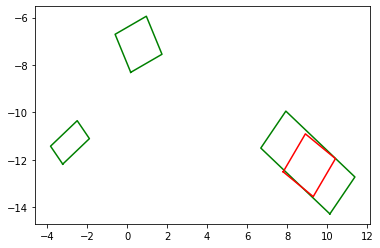

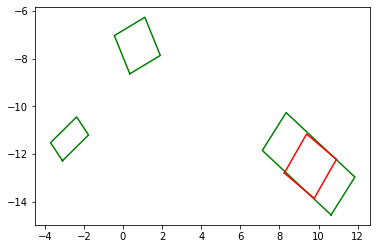

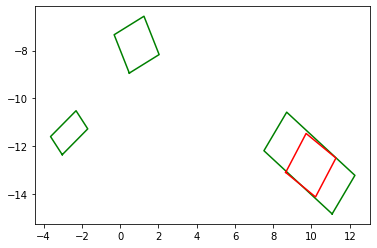

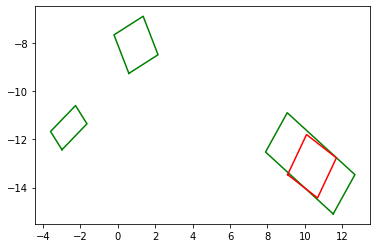

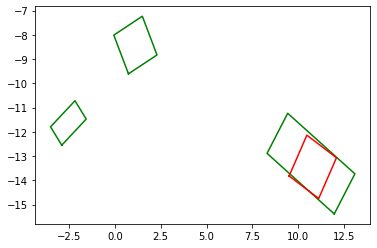

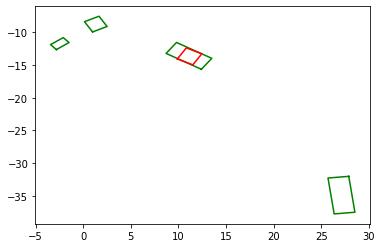

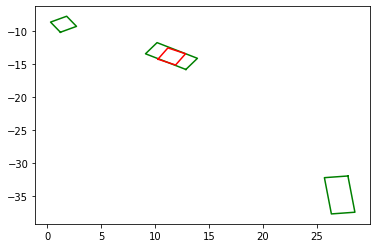

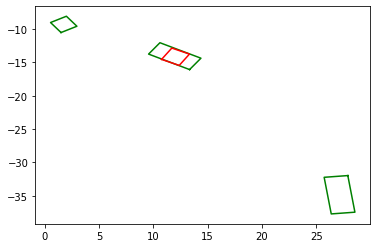

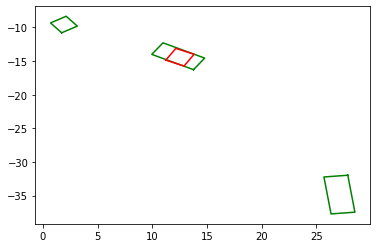

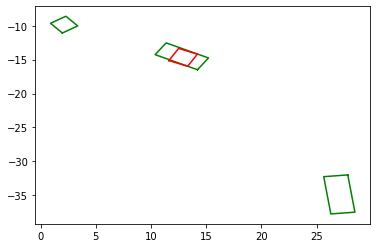

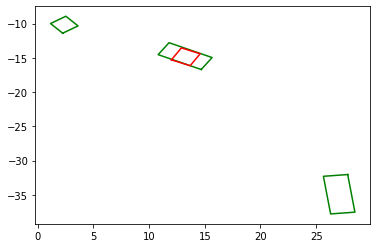

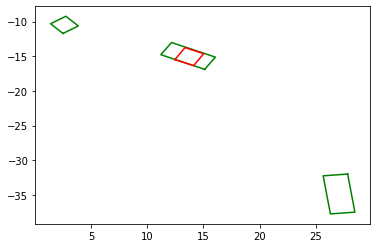

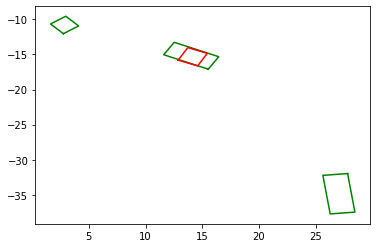

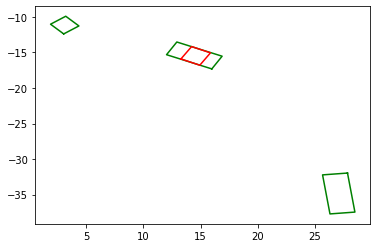

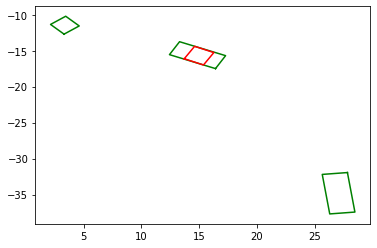

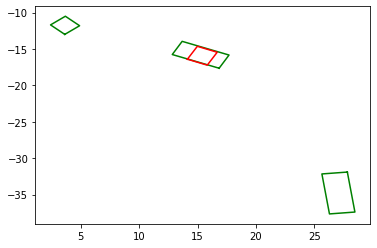

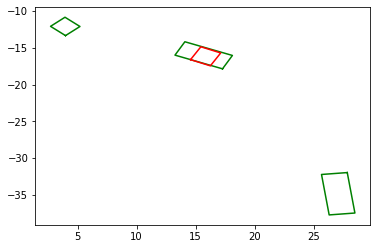

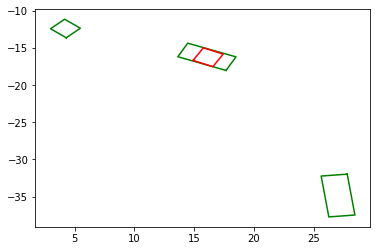

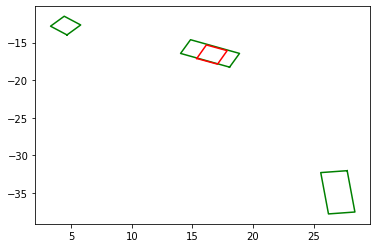

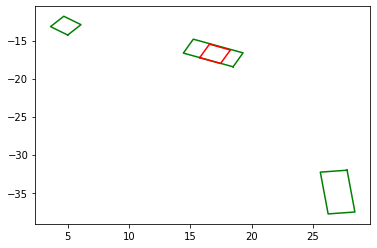

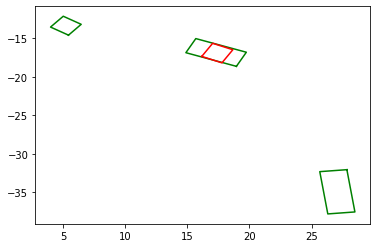

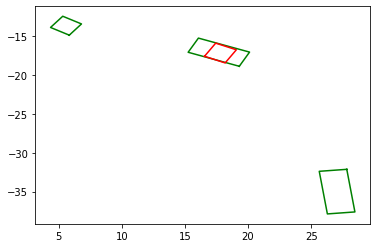

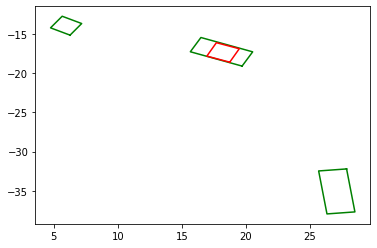

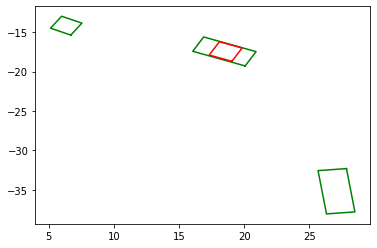

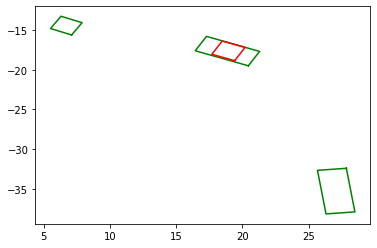

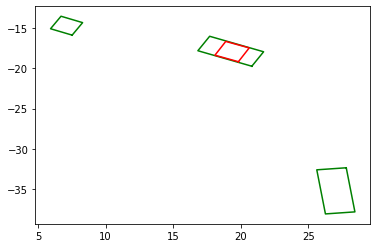

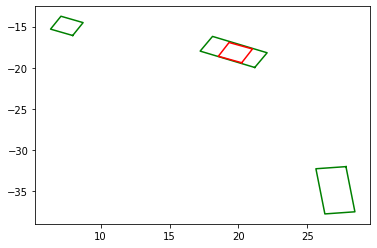

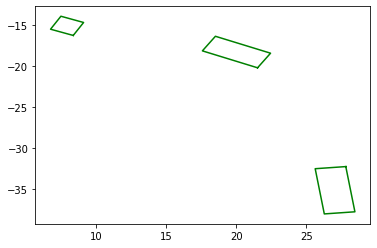

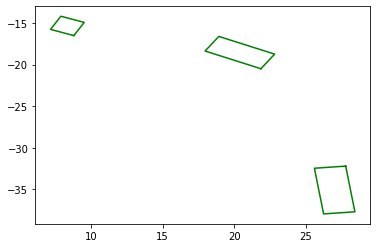

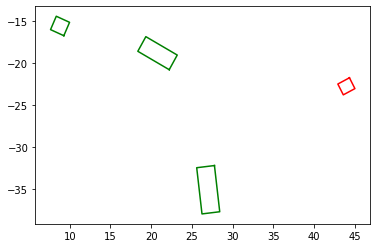

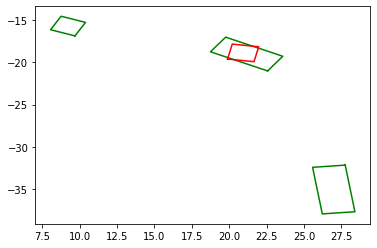

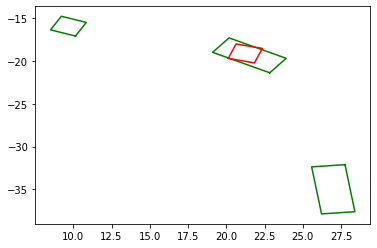

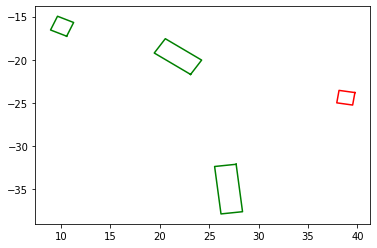

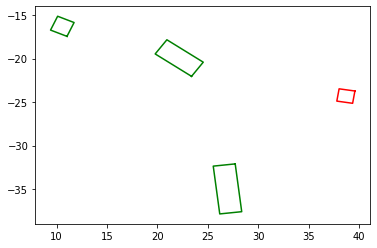

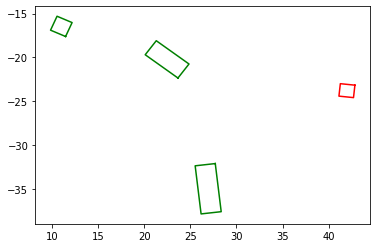

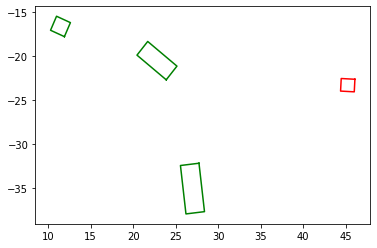

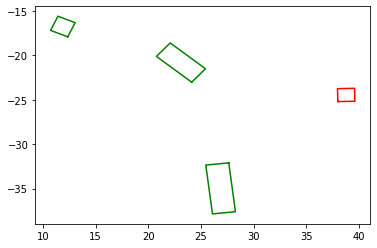

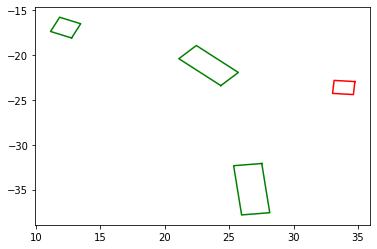

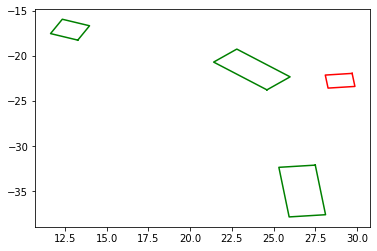

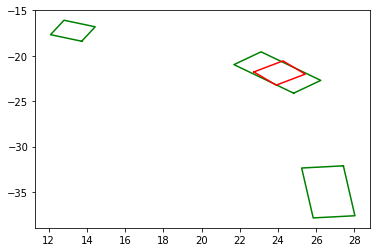

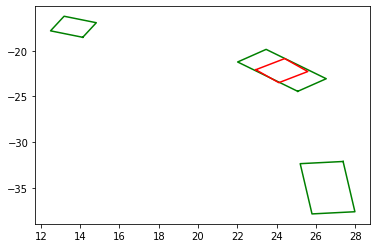

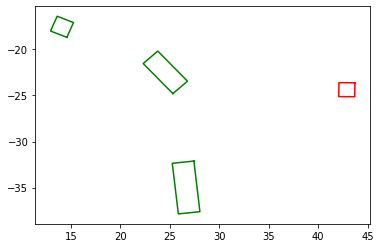

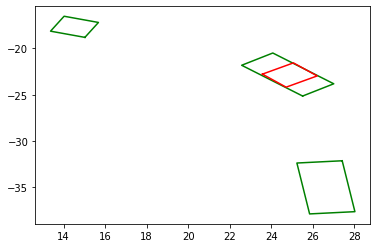

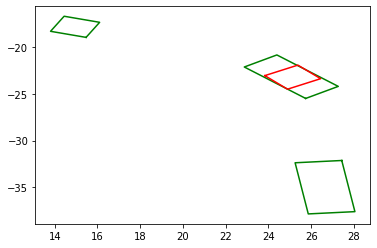

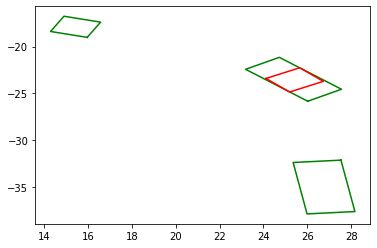

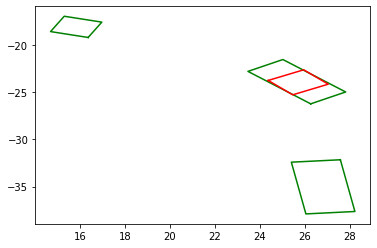

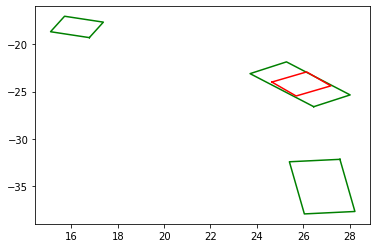

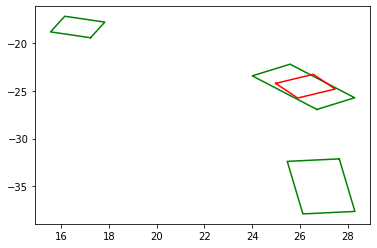

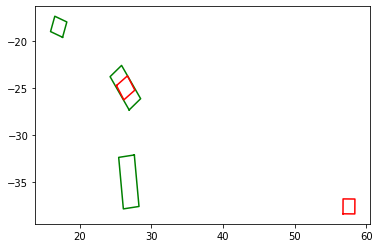

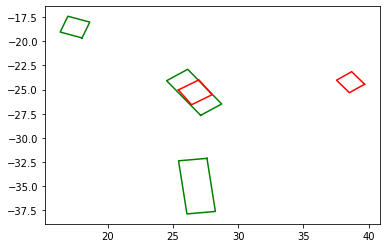

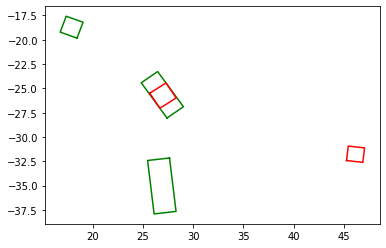

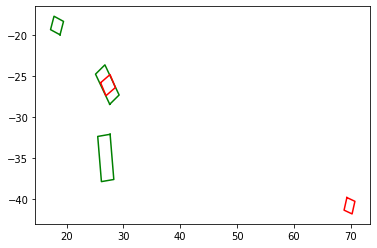

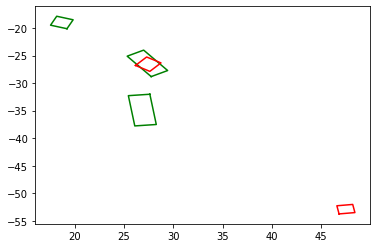

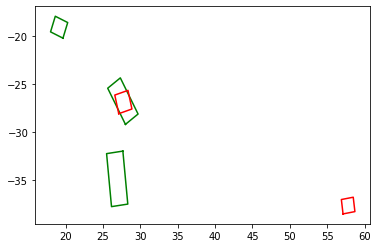

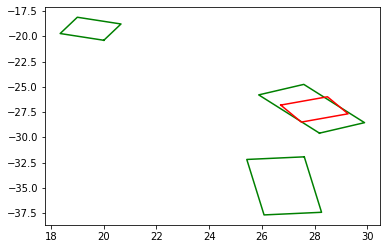

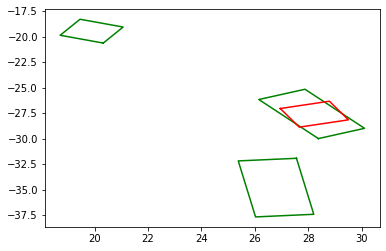

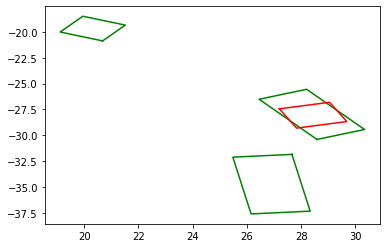

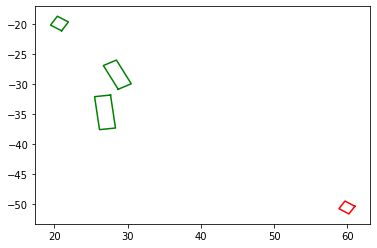

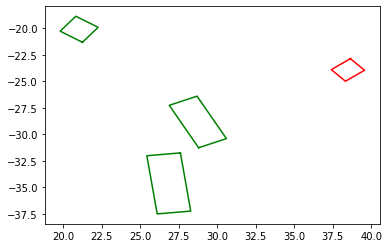

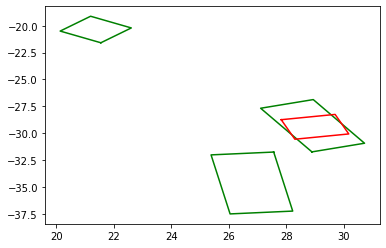

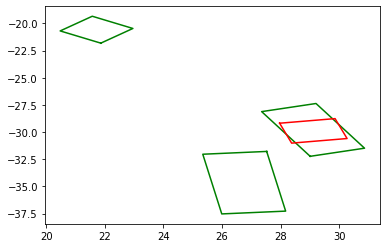

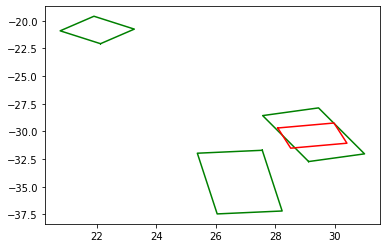

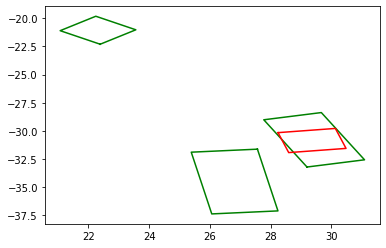

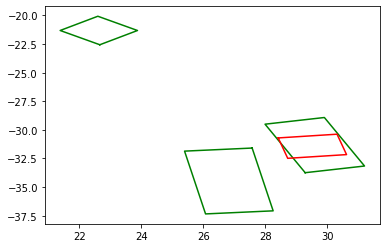

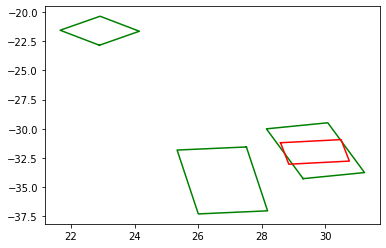

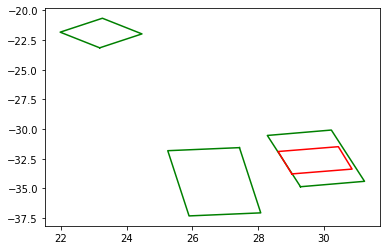

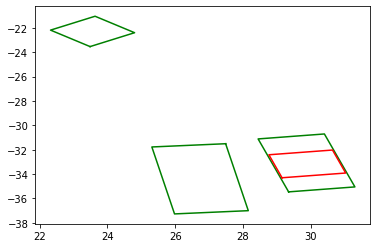

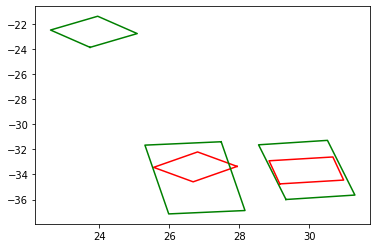

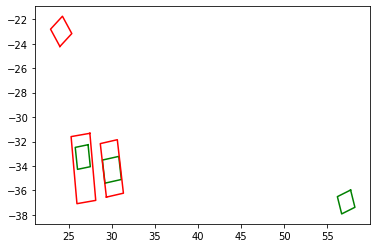

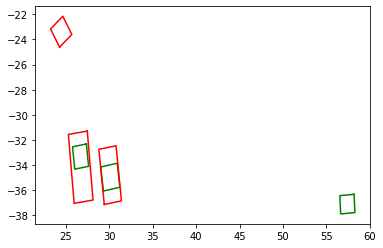

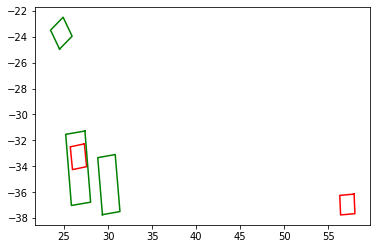

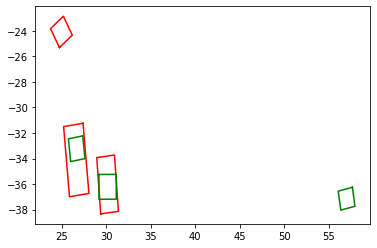

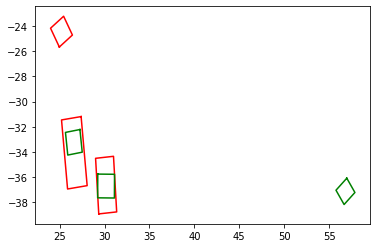

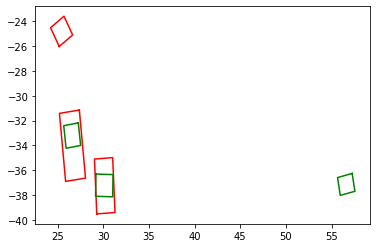

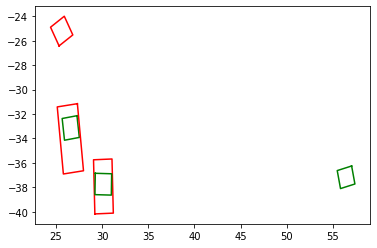

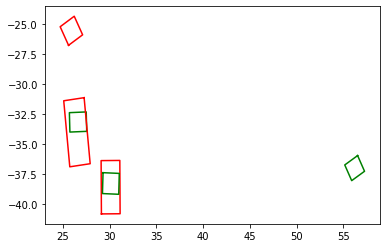

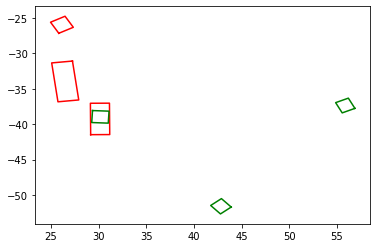

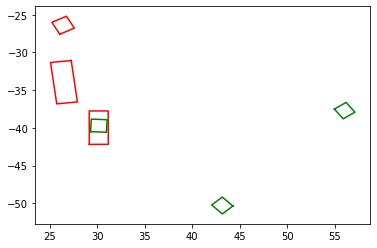

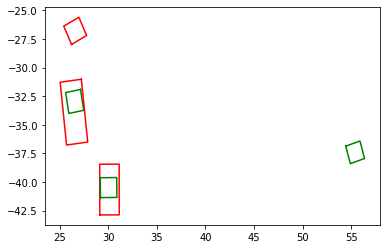

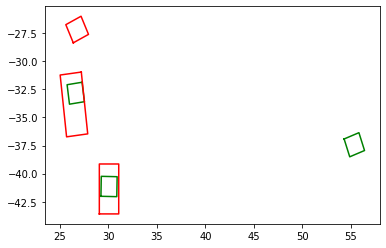

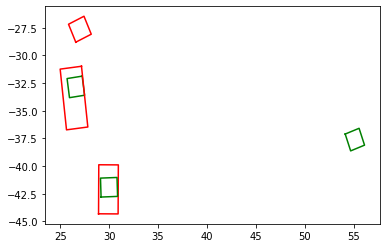

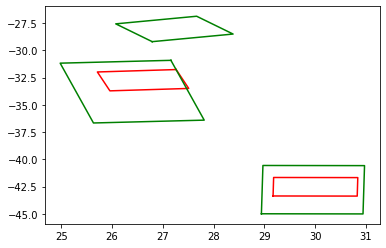

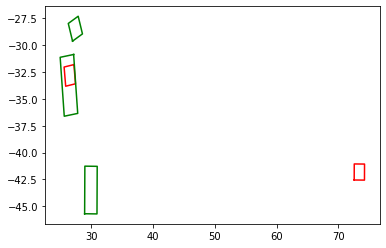

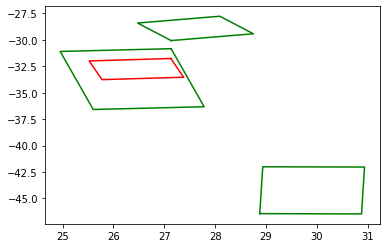

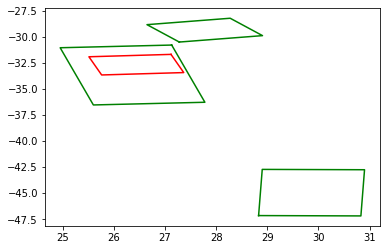

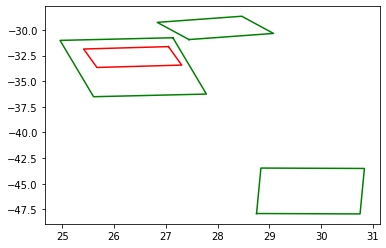

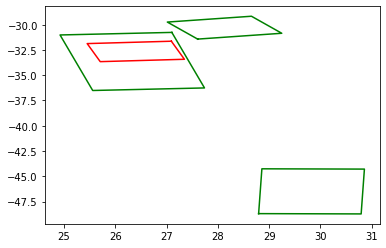

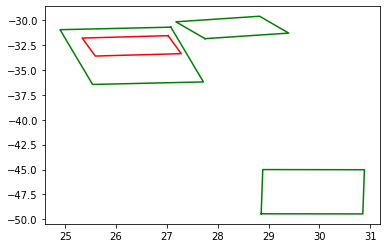

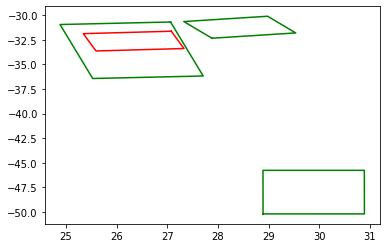

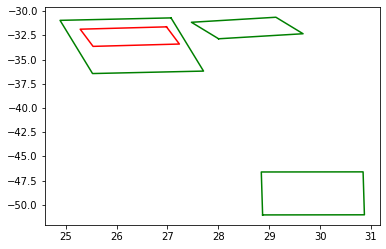

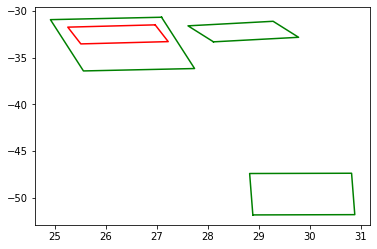

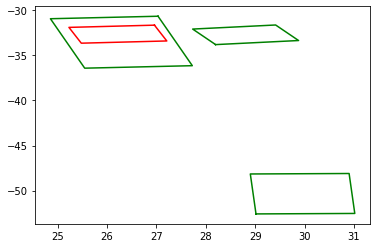

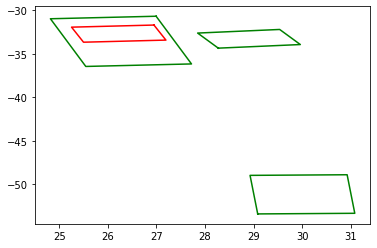

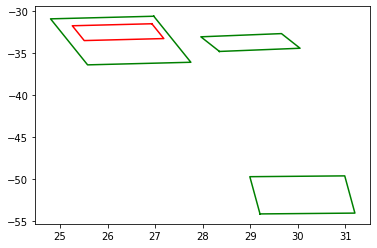

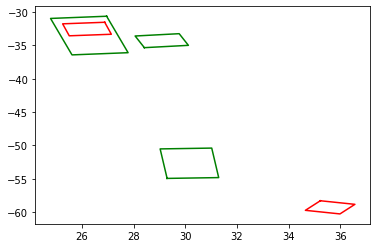

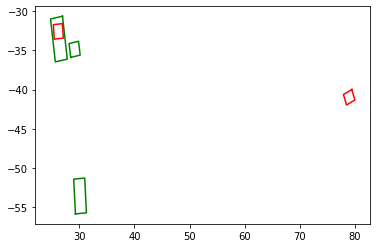

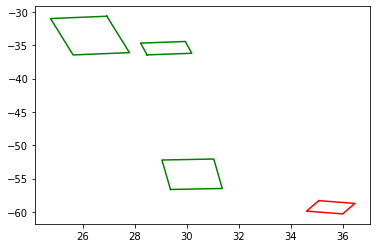

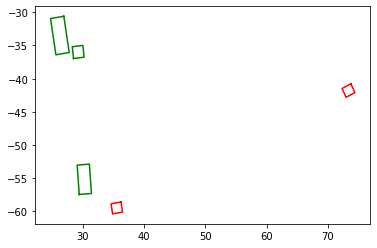

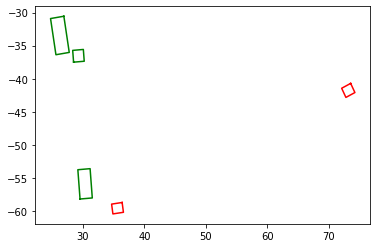

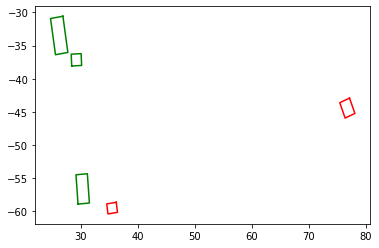

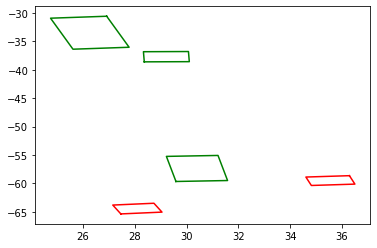

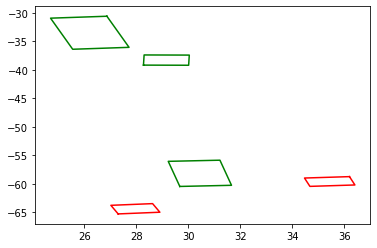

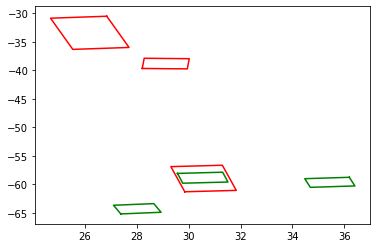

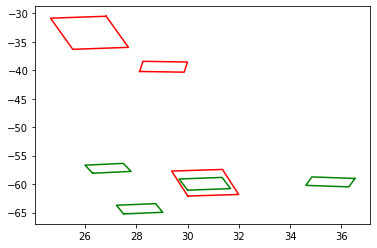

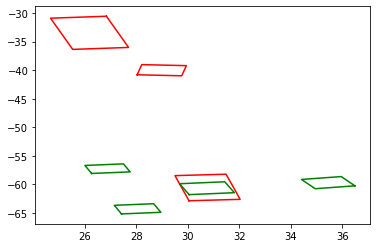

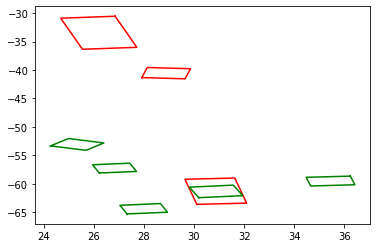

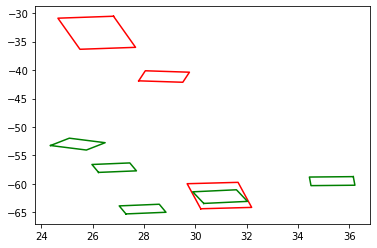

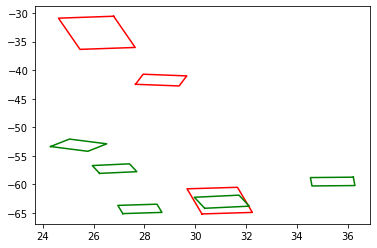

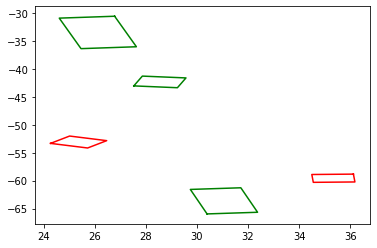

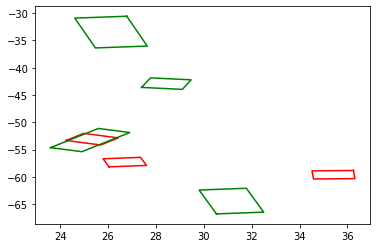

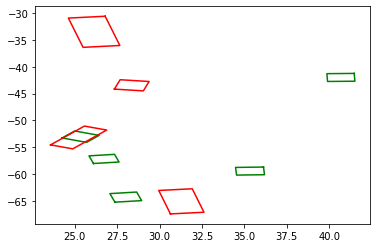

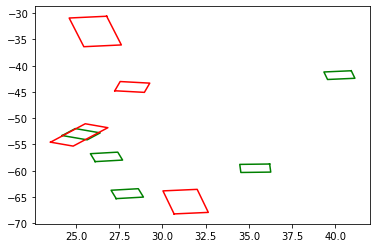

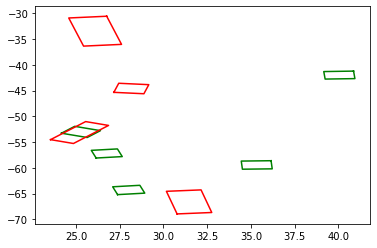

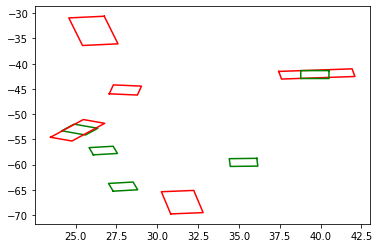

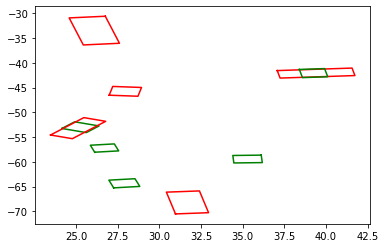

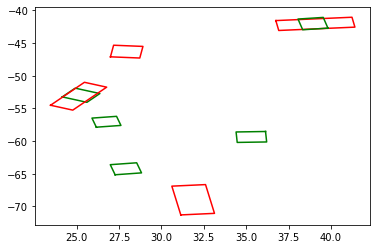

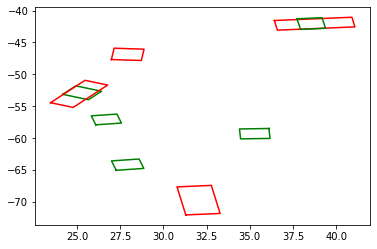

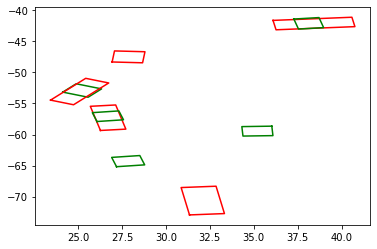

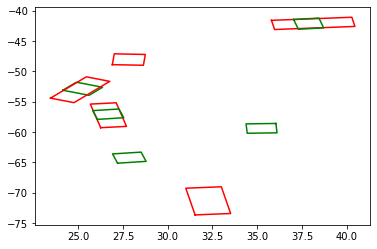

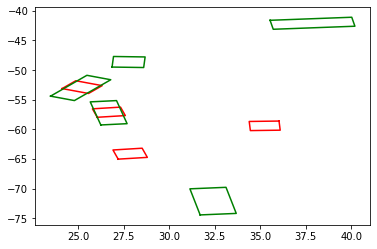

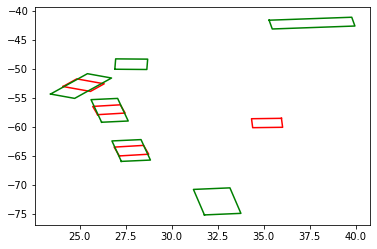

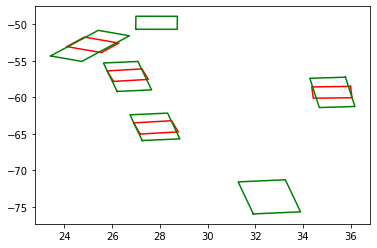

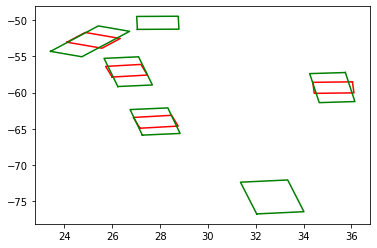

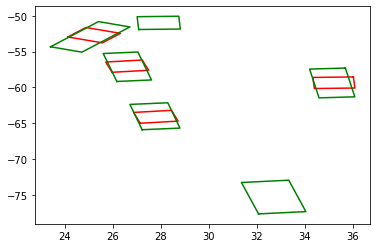

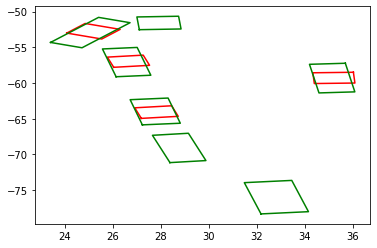

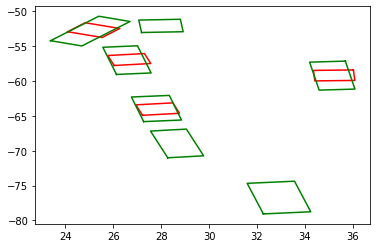

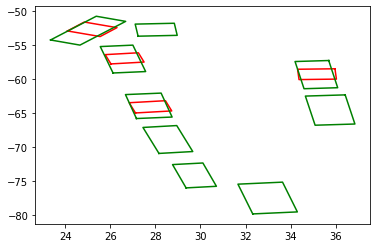

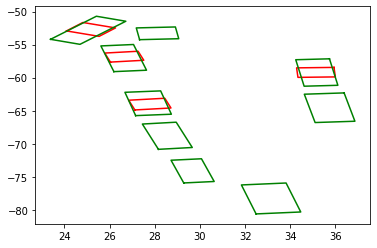

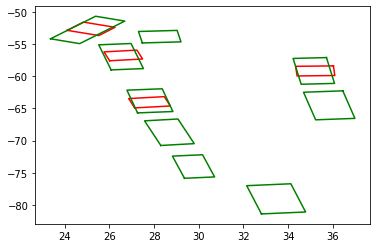

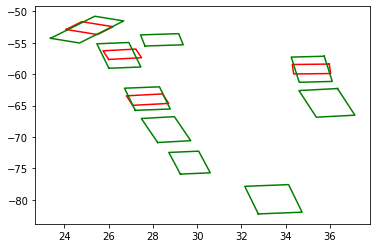

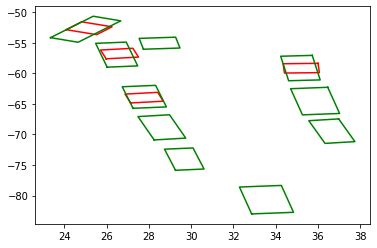

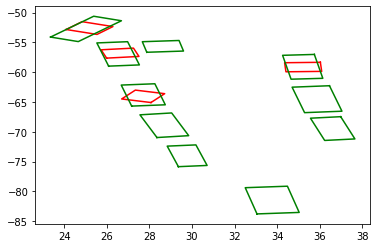

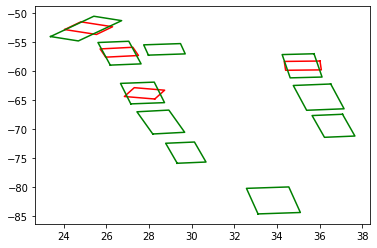

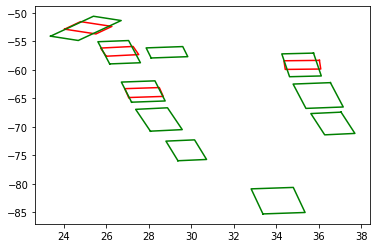

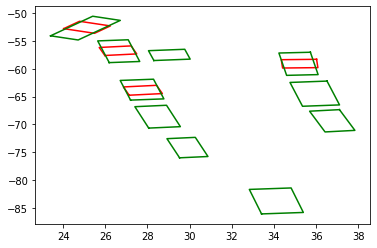

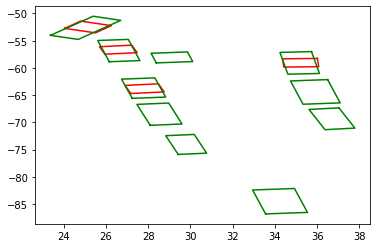

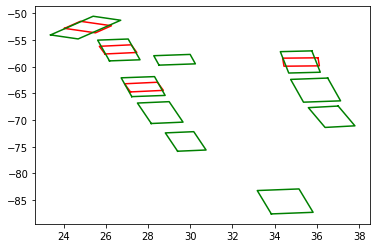

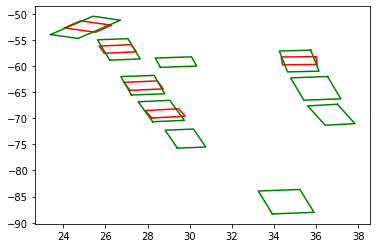

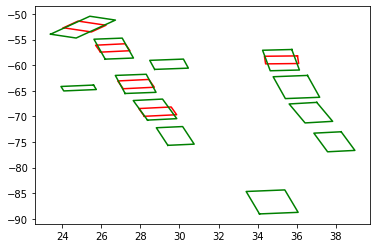

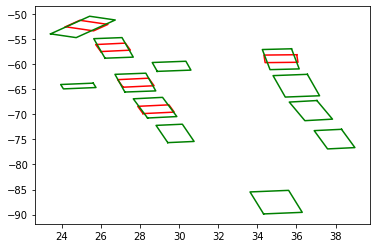

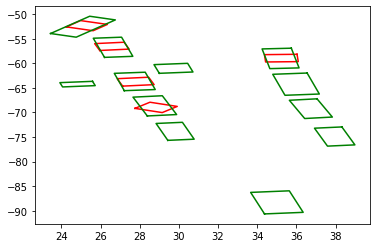

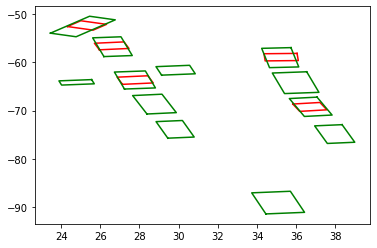

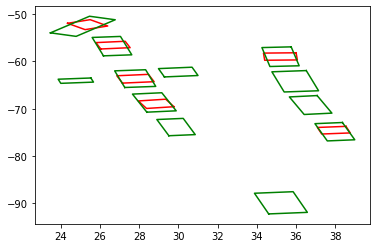

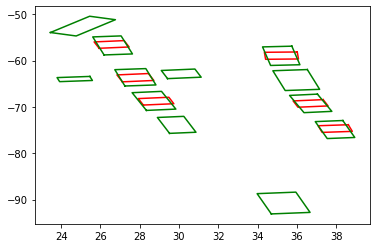

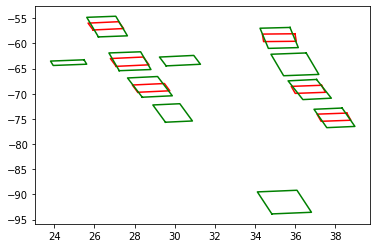

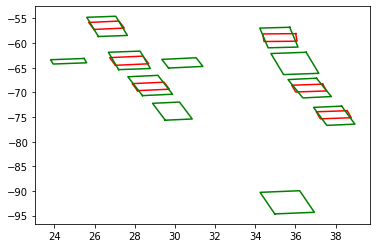

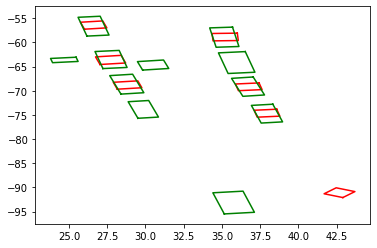

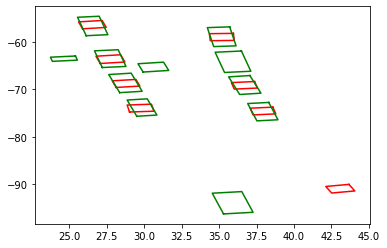

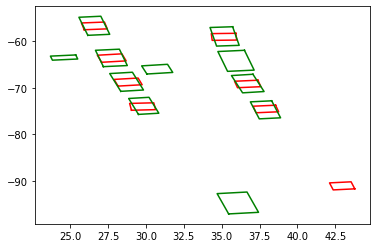

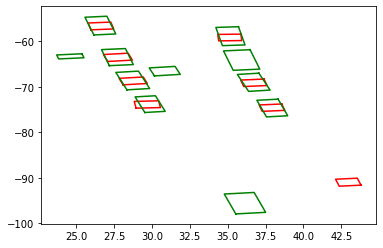

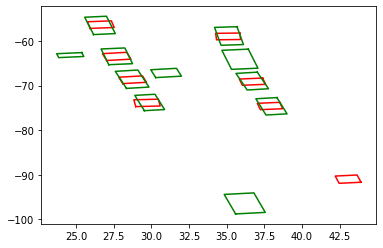

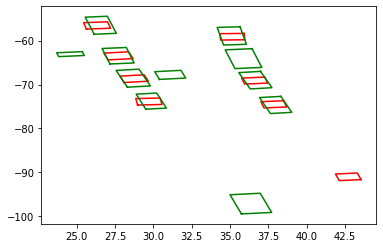

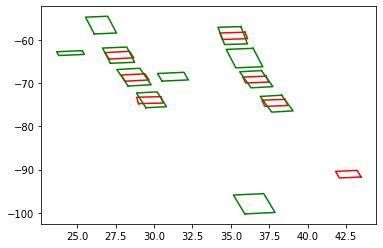

copying files....
img files copied...
mkdir: cannot create directory ‘/home/itiv/Desktop/KITTI_TRACKING_DATA/KITTI_DATASET_ROOT/training/scene//temp_data’: File exists
mkdir: cannot create directory ‘/home/itiv/Desktop/KITTI_TRACKING_DATA/KITTI_DATASET_ROOT/training/scene/velodyne_reduced’: File exists
/home/itiv/anaconda3/envs/secondv1.5/lib/python3.6/site-packages/numba/cuda/envvars.py:17: NumbaWarning: 
Environment variables with the 'NUMBAPRO' prefix are deprecated and consequently ignored, found use of NUMBAPRO_NVVM=/usr/local/cuda/nvvm/lib64/libnvvm.so.

For more information about alternatives visit: ('http://numba.pydata.org/numba-doc/latest/cuda/overview.html', '#cudatoolkit-lookup')
  warnings.warn(errors.NumbaWarning(msg))
/home/itiv/anaconda3/envs/secondv1.5/lib/python3.6/site-packages/numba/cuda/envvars.py:17: NumbaWarning: 
Environment variables with the 'NUMBAPRO' prefix are deprecated and consequently ignored, found use of NUMBAPRO_LIBDEVICE=/usr/local/cuda/nvvm/libdevic

^C
Traceback (most recent call last):
  File "start-kitti-track.py", line 101, in <module>
    fire.Fire()
  File "/home/itiv/anaconda3/envs/secondv1.5/lib/python3.6/site-packages/fire/core.py", line 138, in Fire
    component_trace = _Fire(component, args, parsed_flag_args, context, name)
  File "/home/itiv/anaconda3/envs/secondv1.5/lib/python3.6/site-packages/fire/core.py", line 471, in _Fire
    target=component.__name__)
  File "/home/itiv/anaconda3/envs/secondv1.5/lib/python3.6/site-packages/fire/core.py", line 675, in _CallAndUpdateTrace
    component = fn(*varargs, **kwargs)
  File "start-kitti-track.py", line 57, in kitti_track
    subprocess.Popen(cmd).wait()
  File "/home/itiv/anaconda3/envs/secondv1.5/lib/python3.6/subprocess.py", line 1477, in wait
    (pid, sts) = self._try_wait(0)
  File "/home/itiv/anaconda3/envs/secondv1.5/lib/python3.6/subprocess.py", line 1424, in _try_wait
    (pid, sts) = os.waitpid(self.pid, wait_flags)
KeyboardInterrupt
Traceback (most recent call

FileNotFoundError: [Errno 2] File b'/home/itiv/Desktop/KITTI_TRACKING_DATA/KITTI_DATASET_ROOT/training/scene//result/test/0001.txt' does not exist: b'/home/itiv/Desktop/KITTI_TRACKING_DATA/KITTI_DATASET_ROOT/training/scene//result/test/0001.txt'

In [53]:
      
import motmetrics as mm
import numpy as np  
from datetime import datetime



iou_arr = []
gt_ids = []
det_ids = []
id_counter = 0
accs = []
##create pkl
for scene_num in range(21):
    track(scene_num)
    gt_dict,det_dict = generateCarMakerFiles(scene_num)
    print('###########eval#############')        
    scene_iou_arr,scene_gt_ids,scene_det_ids,id_counter_val = get_iou_for_scene(gt_dict,det_dict,id_counter)
    id_counter = id_counter_val
    #accs.append(get_MOTA_Acc(scene_iou_arr,scene_gt_ids,scene_det_ids))
    det_ids.extend(scene_det_ids)
    gt_ids.extend(scene_gt_ids)
    iou_arr.extend(scene_iou_arr)


acc = get_MOTA_Acc(iou_arr,gt_ids,det_ids)

print('creating metric')

mh = mm.metrics.create()
summary = mh.compute(acc, metrics=mm.metrics.motchallenge_metrics, name='Kitti')
print(summary)

now = datetime.now() # current date and time
date_time = now.strftime("%m/%d/%Y, %H:%M:%S")

with open('KittiEvaluationResults.txt', "a") as resultFile:
    resultFile.write("\n #### "+str(date_time)+' ### \n')
    resultFile.write("Net: "+nets[index]+' \n')


summary.to_csv('EvaluationResults.txt', sep='\t', mode='a',index=True)


    

In [52]:
!pip install shapely

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
  Using cached Shapely-1.7.0-cp36-cp36m-manylinux1_x86_64.whl (1.8 MB)


     num_frames      mota      motp
acc         126  0.676623  0.373086


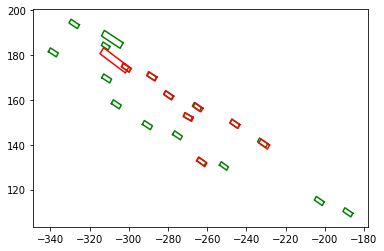

In [189]:
### single scene analysis
det_dict = loadDetectionDict(106,'middle')
gt_dict = load_ground_truth_data(106,'middle')
iou_arr,gt_ids,det_ids = get_iou_for_scene(gt_dict,det_dict)
acc = get_MOTA_Acc(iou_arr,gt_ids,det_ids)

mh = mm.metrics.create()
summary = mh.compute(acc, metrics=['num_frames', 'mota', 'motp'], name='acc')
print(summary)